## Predicting Customer Response to Telemarketing Campaigns for Term Deposit

### 1. Project Background <a class="anchor" id="1"></a>
Nowadays, marketing spending in the banking industry is massive, meaning that it is essential for banks to optimize marketing strategies and improve effectiveness. Understanding customers’ need leads to more effective marketing plans, smarter product designs and greater customer satisfaction.

<b>Main Objective: increase the effectiveness of the bank's telemarketing campaign
This project will enable the bank to develop a more granular understanding of its customer base, predict customers' response to its telemarketing campaign and establish a target customer profile for future marketing plans.

By analyzing customer features, such as demographics and transaction history, the bank will be able to predict customer saving behaviours and identify which type of customers is more likely to make term deposits. The bank can then focus its marketing efforts on those customers. This will not only allow the bank to secure deposits more effectively but also increase customer satisfaction by reducing undesirable advertisements for certain customers.

#### Load the Raw Data

This dataset is about the direct phone call marketing campaigns, which aim to promote term deposits among existing customers, by a Portuguese banking institution from May 2008 to November 2010. It is publicly available in the UCI Machine learning Repository, which can be retrieved from http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#.

In [ ]:
# Supressing warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat
import statsmodels.api as smf
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold , GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix as cm, accuracy_score as ac, classification_report as report,\
roc_curve, roc_auc_score , recall_score , precision_score, f1_score

In [ ]:
from google.colab import files
upload = files.upload()

Saving bank-full.csv to bank-full.csv


In [ ]:
# Importing Dataset
raw_data = pd.read_csv('bank-full.csv', delimiter=';')
raw_data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


#### 1.1 About the Dataset <a class="anchor" id="1.1"></a>
##### Attribute Information:

+ age (numeric)
+ job : type of job (categorical:admin.','bluecollar','entrepreneur','housemaid','management','retired','selfemployed','services','student','technician','unemployed','unknown')
+ marital : marital status (categorical:'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
+ education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
+ default: has credit in default? (categorical: 'no','yes','unknown')
+ balance: average yearly balance, in euros (numeric)
+ housing: has housing loan? (categorical: 'no','yes','unknown')
+ loan: has personal loan? (categorical: 'no','yes','unknown')
+ contact: contact communication type (categorical:'cellular','telephone')
+ day: last contact day of the month (numeric 1 -31)
+ month: last contact month of year (categorical: 'jan', 'feb','mar', …, 'nov', 'dec')
+ duration: last contact duration, in seconds (numeric).

<b>Important note:</b> this attribute highly affects the output target (e.g., ifduration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known.Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic
predictive model.

+ campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
+ pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
+ previous: number of contacts performed before this campaign and for this client (numeric)
+ poutcome: outcome of the previous marketing campaign(categorical: 'failure','nonexistent','success')
+ target: has the client subscribed a term deposit? (binary:"yes","no")

#### [Table of Contents](#0.1)

## 2. Data Exploration <a class="anchor" id="2"></a>

#### A Binary Classification Task as our classes to predict is 'Yes' or 'No' a Binomial Distribution

In [ ]:
# print shape of dataset with rows and columns
print(raw_data.shape)
# print top 5 records
raw_data.head()

(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


#### Descriptive Statistics

In [ ]:
raw_data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


#### All the columns data types are correctly identified

### In Data Analysis we will analyze to find out the below stuff
+ Missing values
+ All the Numerical Variables
+ Distribution of the Numerical Variables
+ Categorical Variables
+ Cardinality of Categorical Variables
+ Outliers
+ Relationshop between independent and dependent feature (Target)

#### [Table of Contents](#0.1)

### 2.1 Missing Values <a class="anchor" id="2.1"></a>

In [ ]:
raw_data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

So we see that there are no missing values.

### Duplicated Values

#### print the duplicated rows

In [ ]:
raw_data[raw_data.duplicated()]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y


In [ ]:
raw_data[raw_data.duplicated()].shape

(0, 17)

#### [Table of Contents](#0.1)

### Numerical Variables

In [ ]:
# List of Numerical Variables
numerical_features=[feature for feature in raw_data.columns if raw_data[feature].dtypes != 'O']

print('Number of numerical variables:', len(numerical_features))

# Visualize the numerical variables
raw_data[numerical_features].head()

Number of numerical variables: 7


,age,balance,day,duration,campaign,pdays,previous
0,58,2143,5,261,1,-1,0
1,44,29,5,151,1,-1,0
2,33,2,5,76,1,-1,0
3,47,1506,5,92,1,-1,0
4,33,1,5,198,1,-1,0


#### Discrete Feature
+ Numerical variables are usually of 2 types
+ Continuous variable and discrete variable

In [ ]:
discrete_feature=[feature for feature in numerical_features if len(raw_data[feature].unique())<25 and feature not in year_feature]
print('Discrete Variables Count: {}'.format(len(discrete_feature)))

Discrete Variables Count: 0


#### Continuous Variable

In [ ]:
continuous_feature=[feature for feature in numerical_features if feature not in discrete_feature]
print('Continuous Feature Count {}'.format(len(continuous_feature)))

Continuous Feature Count 7


In [ ]:
raw_data.corr()

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.097783,-0.009120,-0.004648,0.004760,-0.023758,0.001288
balance,0.097783,1.000000,0.004503,0.021560,-0.014578,0.003435,0.016674
day,-0.009120,0.004503,1.000000,-0.030206,0.162490,-0.093044,-0.051710
duration,-0.004648,0.021560,-0.030206,1.000000,-0.084570,-0.001565,0.001203
campaign,0.004760,-0.014578,0.162490,-0.084570,1.000000,-0.088628,-0.032855
pdays,-0.023758,0.003435,-0.093044,-0.001565,-0.088628,1.000000,0.454820
previous,0.001288,0.016674,-0.051710,0.001203,-0.032855,0.454820,1.000000


## 3. Exploratory Data Analysis<a class="anchor" id="3"></a>

To obtain a better understanding of the dataset, the distribution of key variables and the relationships among them were plotted.

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0.5, 0, 'age'),
  Text(1.5, 0, 'balance'),
  Text(2.5, 0, 'day'),
  Text(3.5, 0, 'duration'),
  Text(4.5, 0, 'campaign'),
  Text(5.5, 0, 'pdays'),
  Text(6.5, 0, 'previous')])

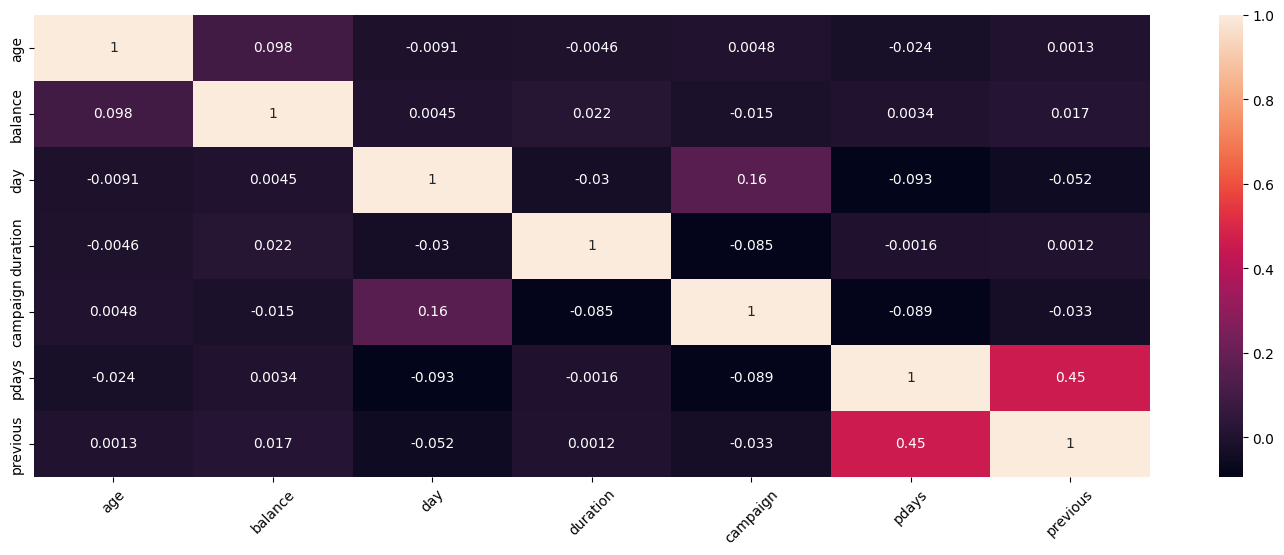

In [ ]:
fig= plt.figure(figsize=(18, 6))
sns.heatmap(raw_data.corr(), annot=True);
plt.xticks(rotation=45)

The scatter matrix does not reveal any clear relationship among age, balance, duration and campaign.

To investigate more about correlation, a correlation matrix was plotted with all qualitative variables. Clearly, “campaign outcome” has a strong correlation with “duration”, a moderate correlation with “previous contacts”, and mild correlations between “balance”, “month of contact” and “number of campaign”. Their influences on campaign outcome will be investigated further in the machine learning part.

### Lets analyze the continuous values by creating histograms to understand the distribution of the numerical features

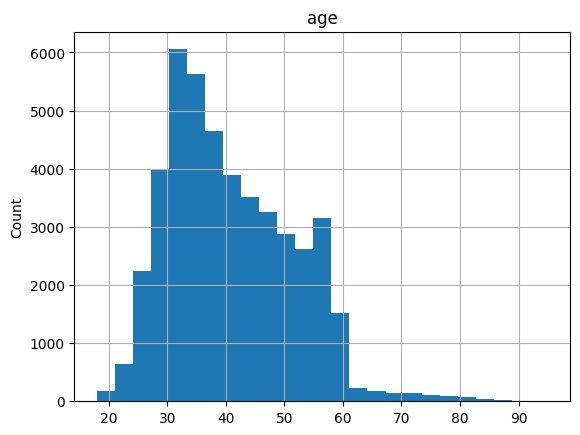

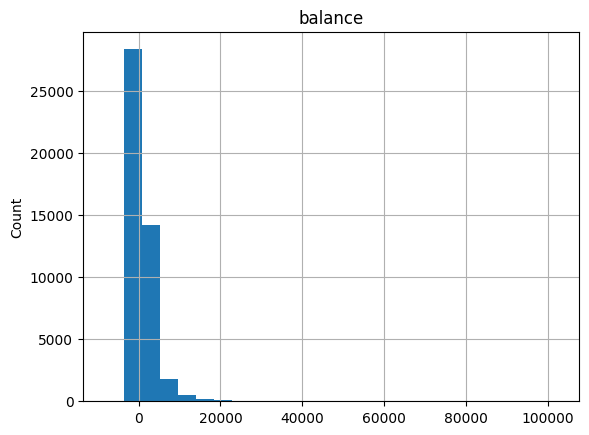

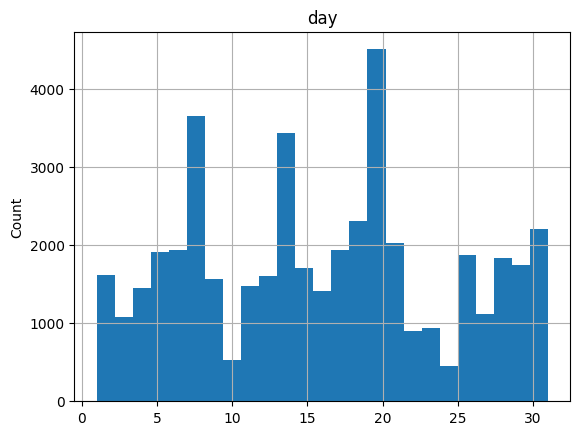

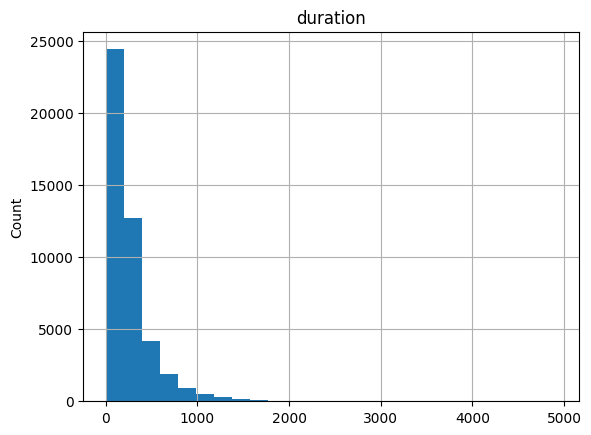

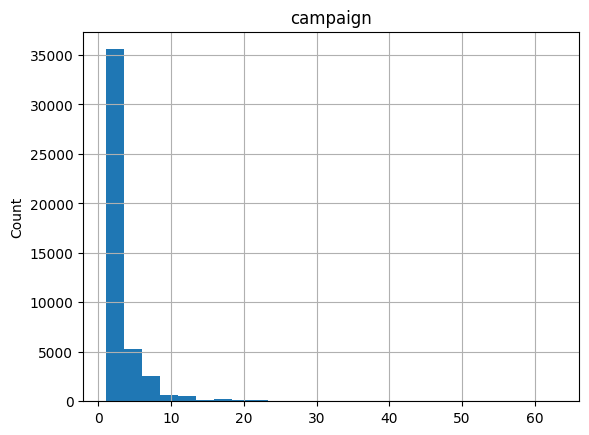

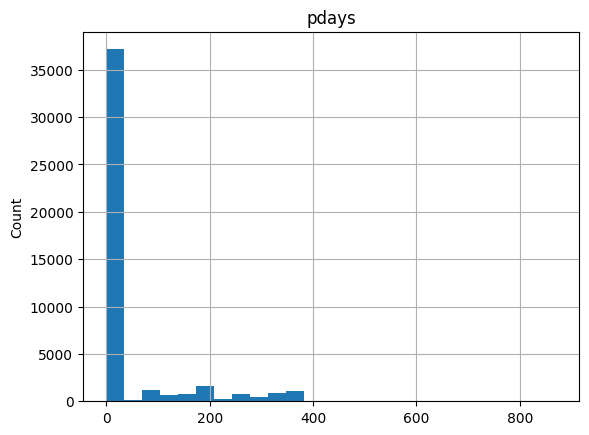

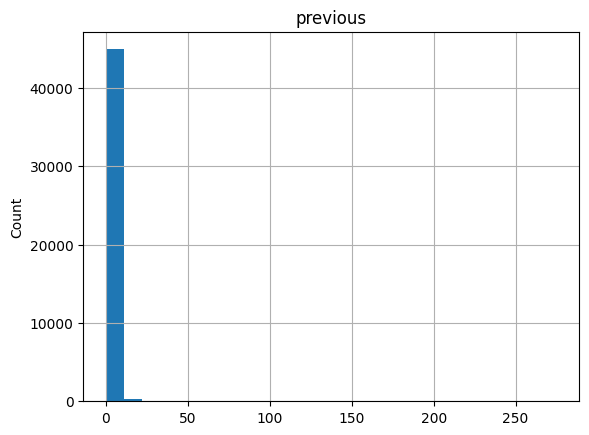

In [ ]:
for feature in continuous_feature:
    data=raw_data.copy()
    data[feature].hist(bins=25)
    plt.ylabel('Count')
    plt.title(feature)
    plt.show()

## Log transformation
+ We will be using logarithmic transformation

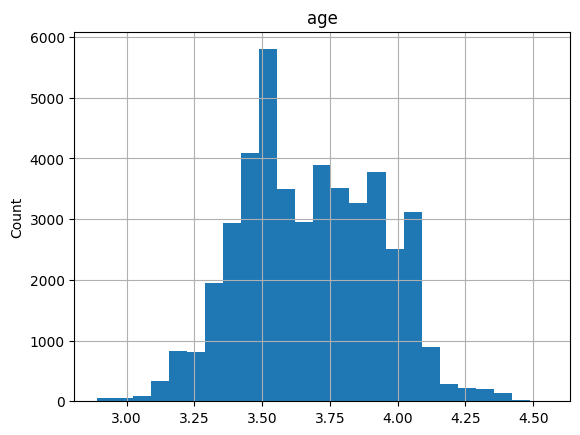

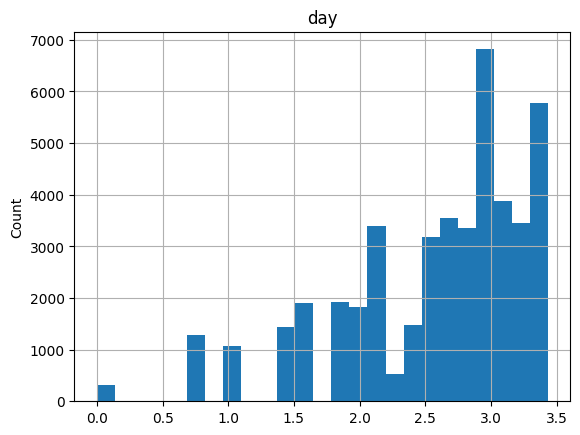

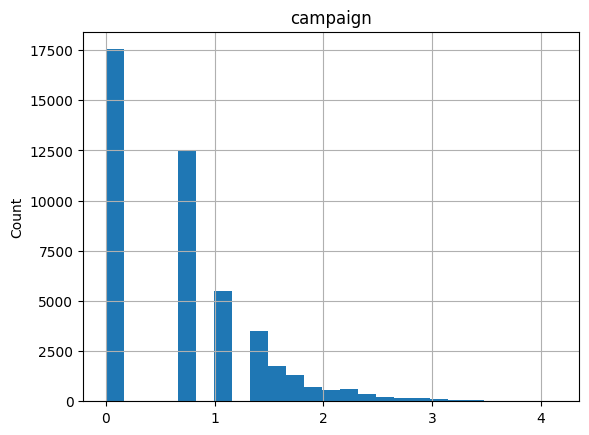

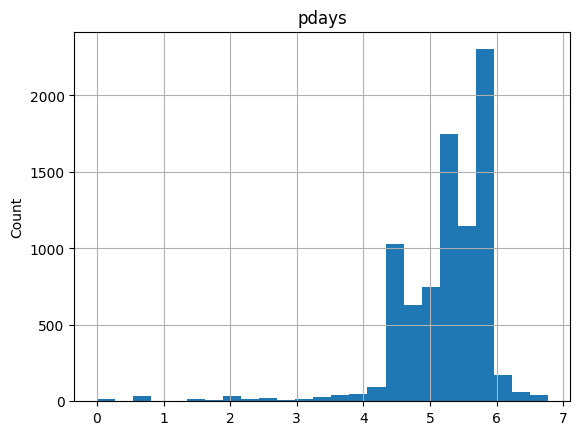

In [ ]:
for feature in continuous_feature:
    data=raw_data.copy()
    if 0 in data[feature].unique():
        pass
    else:
        data[feature]=np.log(data[feature])
        data[feature].hist(bins=25)
        plt.ylabel('Count')
        plt.title(feature)
        plt.show()

## [Table of Contents](#0.1)

### 3.1 Outliers Detection<a class="anchor" id="3.1"></a>

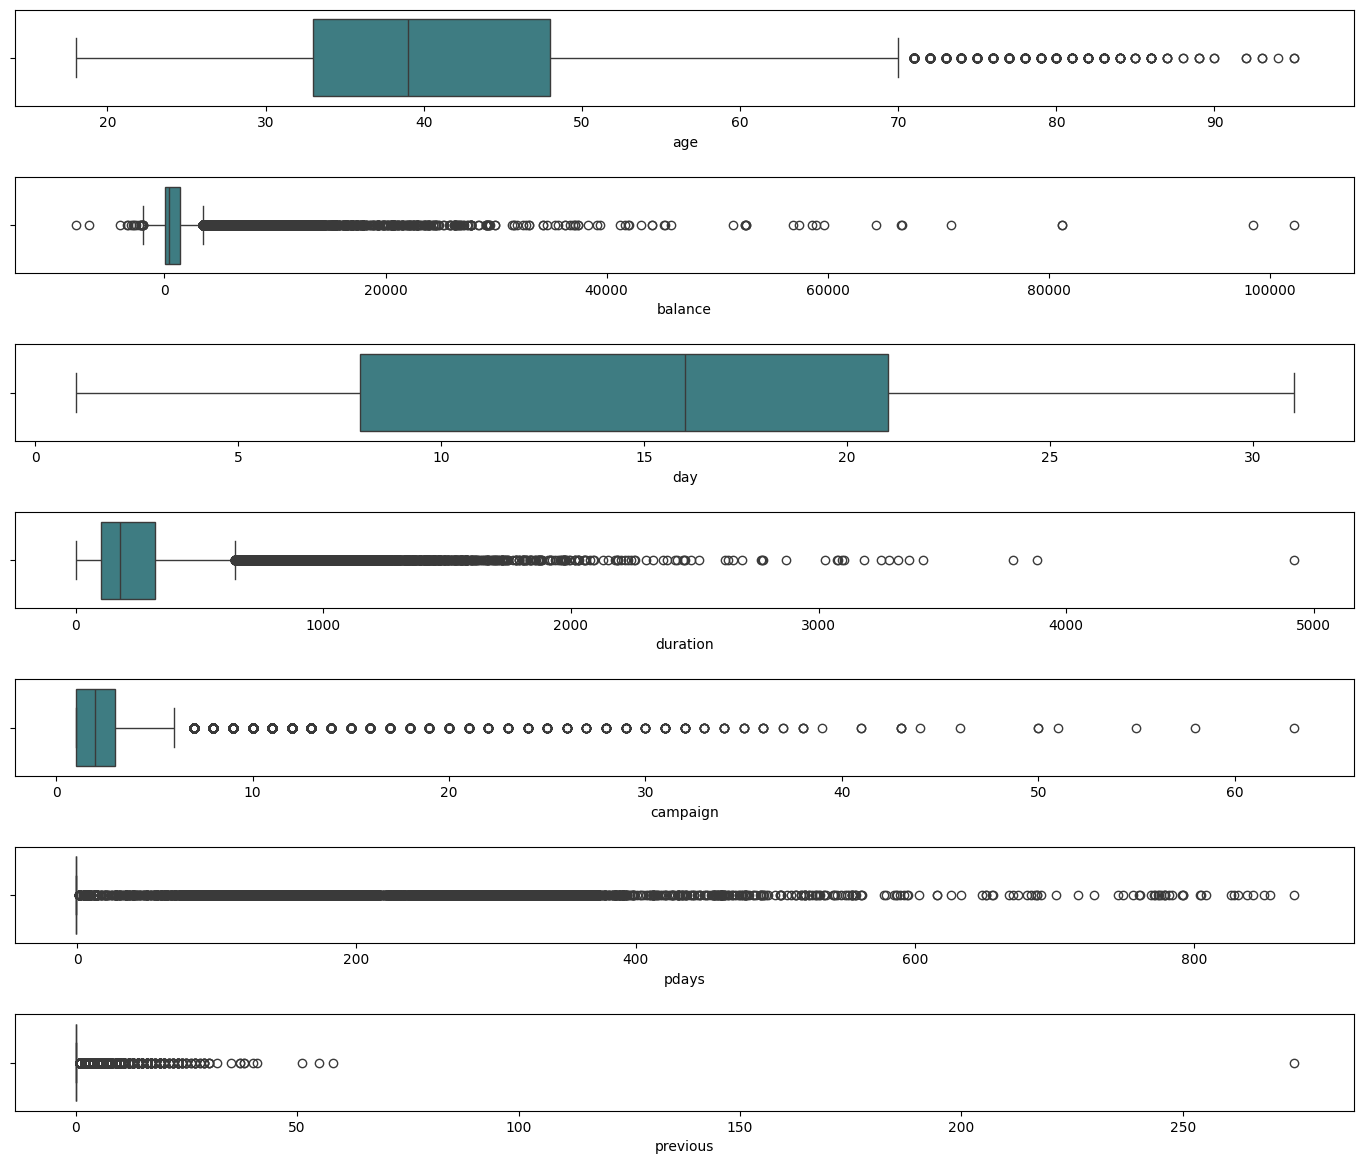

In [ ]:
ot=raw_data.copy()
fig, axes=plt.subplots(7,1,figsize=(14,12),sharex=False,sharey=False)
sns.boxplot(x='age',data=ot,palette='crest',ax=axes[0])
sns.boxplot(x='balance',data=ot,palette='crest',ax=axes[1])
sns.boxplot(x='day',data=ot,palette='crest',ax=axes[2])
sns.boxplot(x='duration',data=ot,palette='crest',ax=axes[3])
sns.boxplot(x='campaign',data=ot,palette='crest',ax=axes[4])
sns.boxplot(x='pdays',data=ot,palette='crest',ax=axes[5])
sns.boxplot(x='previous',data=ot,palette='crest',ax=axes[6])
plt.tight_layout(pad=2.0)

#### There are lot of outliers present in the dataframe but we can't drop them because they are present in a very large quantity and can be important for model building

#### After Log-Transformation

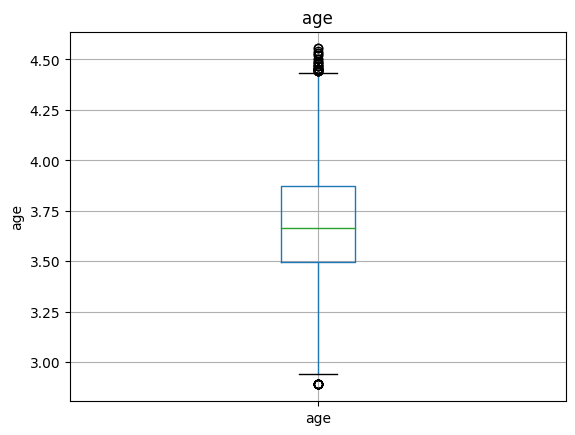

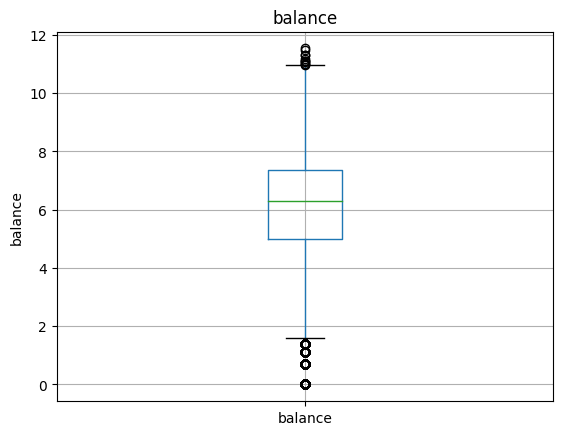

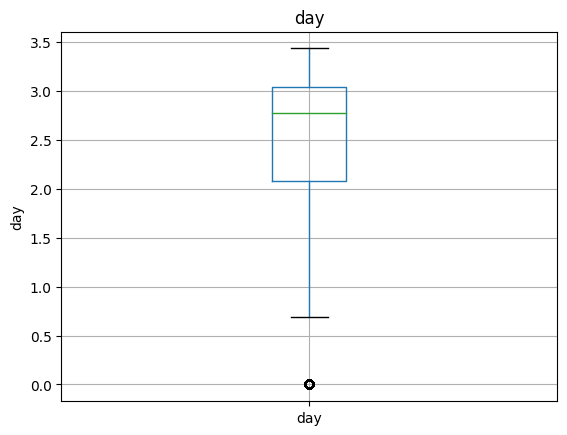

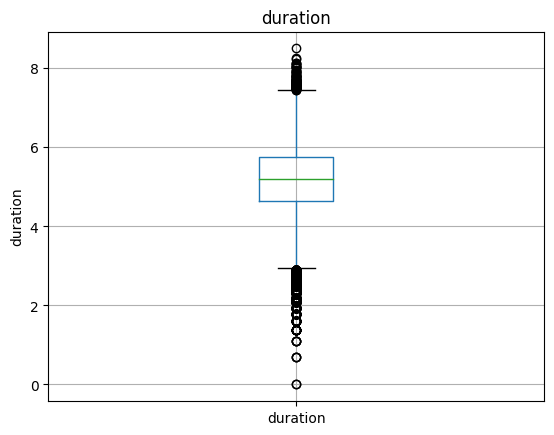

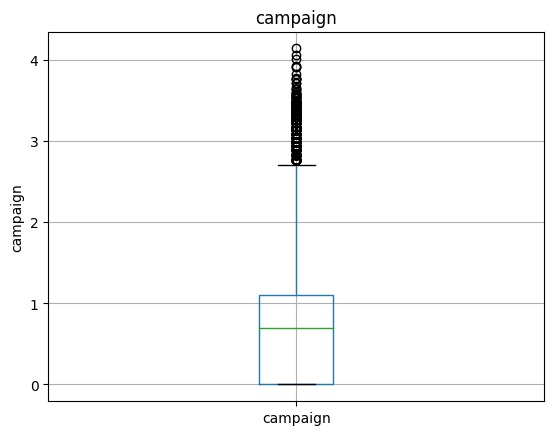

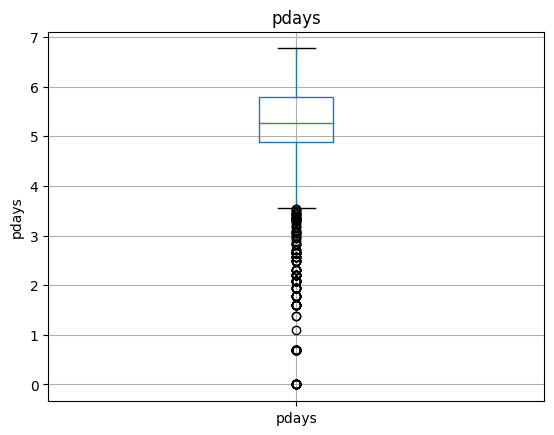

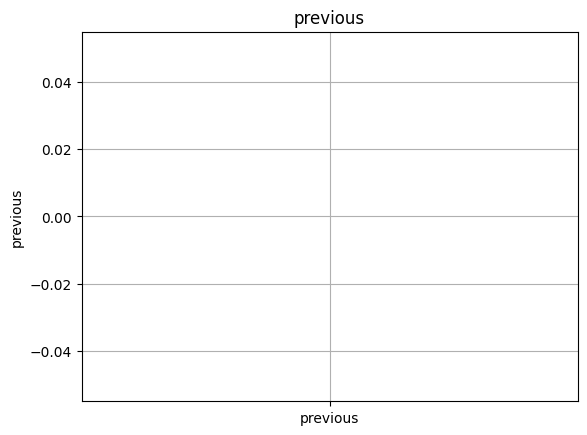

In [ ]:
for feature in continuous_feature:
    data=raw_data.copy()
    data[feature]=np.log(data[feature])
    data.boxplot(column=feature)
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

## [Table of Contents](#0.1)

### 3.2 Visualize the distribution of 'age' and 'balance'<a class="anchor" id="3.2"></a>

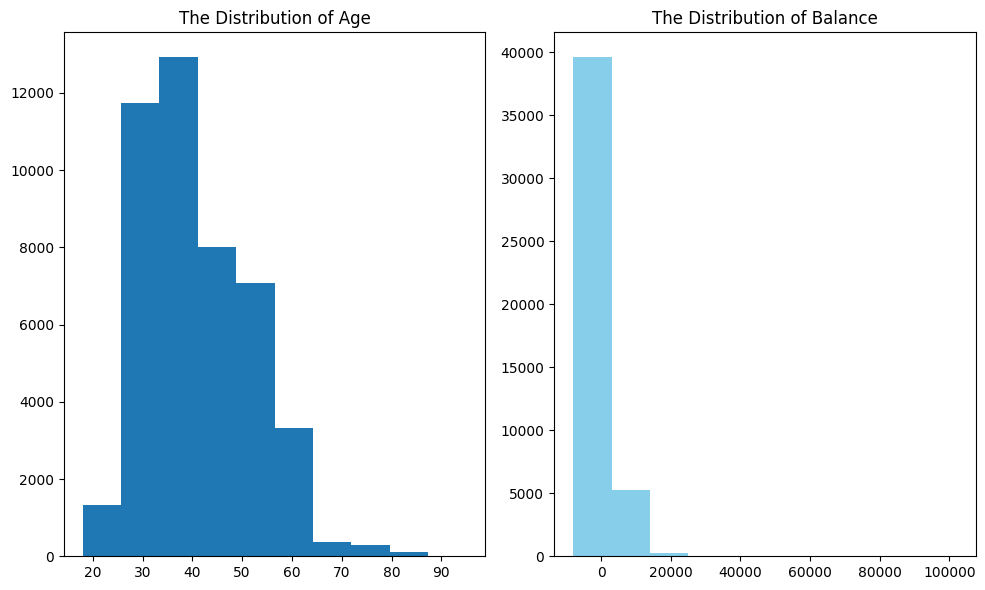

In [ ]:
dist_age_balance = plt.figure(figsize = (10,6))

ra1 = dist_age_balance.add_subplot(1,2,1)
ra2 = dist_age_balance.add_subplot(1,2,2)

ra1.hist(raw_data['age'])
ra1.set_title('The Distribution of Age')

ra2.hist(raw_data['balance'], color = 'skyblue')
ra2.set_title('The Distribution of Balance')

plt.tight_layout()
plt.show()

In [ ]:
raw_data[['age','balance']].describe()

,age,balance
count,45211.000000,45211.000000
mean,40.936210,1362.272058
std,10.618762,3044.765829
min,18.000000,-8019.000000
25%,33.000000,72.000000
50%,39.000000,448.000000
75%,48.000000,1428.000000
max,95.000000,102127.000000


+ The distribution of age: In its telemarketing campaigns, clients called by the bank have an extensive age range, from 18 to 95 years old. However, a majority of customers called is in the age of 30s and 40s (33 to 48 years old fall within the 25th to 75th percentiles). The distribution of customer age is fairly normal with a small standard deviation.

+ The distribution of balance: The range of balance is still massive, from a minimum of -8019 to a maximum of 102127 euros, giving a range of 110146 euros. The distribution of balance has a huge standard deviation relative to the mean, suggesting large variabilities in customers' balance levels.

## [Table of Contents](#0.1)

### 3.3 Visualize the relationship between 'duration' & 'campaign' <a class="anchor" id="3.3"></a>

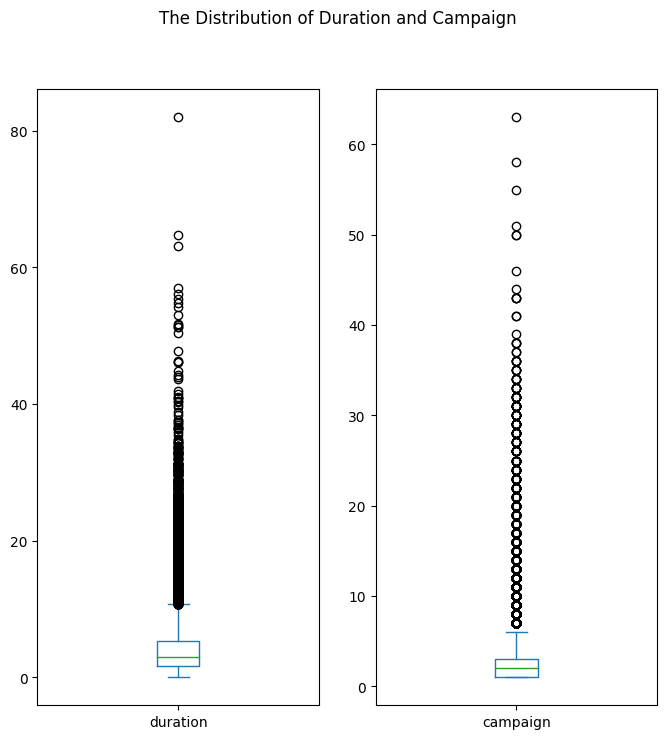

In [ ]:
# Change the unit of 'duration' from seconds to minutes
df1 = data.copy()
df1['duration'] = df1['duration'].apply(lambda n:n/60).round(2)
df1[['duration','campaign']].plot(kind = 'box',
                                                      figsize = (8,8),
                                                      subplots = True, layout = (1,2),
                                                      sharex = False, sharey = False,
                                                      title='The Distribution of Duration and Campaign')
plt.show()

In [ ]:
df1[['duration','campaign']].describe()

,duration,campaign
count,45211.000000,45211.000000
mean,4.302729,2.763841
std,4.292132,3.098021
min,0.000000,1.000000
25%,1.720000,1.000000
50%,3.000000,2.000000
75%,5.320000,3.000000
max,81.970000,63.000000


The distribution of duration: As observed from the box plot, the duration of contact has a median of 3 minutes, with an interquartile range of 1.73 minutes to 5.3 minutes. The left-skewed boxplot indicates that most calls are relatively short. Also, there is a large number of outliers ranging from 10 minutes to 40 minutes, which are worth further study.

The distribution of campagin: About half of the clients have been contacted by the bank for the second time, while 25% was first introduced to the term deposit. Most clients have been reached by the bank for one to three times, which is reasonable. However, some clients have been contacted by as high as 58 times, which is not normal. These clients may have some special needs that require frequent contact.

## [Table of Contents](#0.1)

### 3.4 Now let's look how numerical columns affect term deposit subscription. <a class="anchor" id="3.4"></a>

In [ ]:
#balance and deposit

b_df = pd.DataFrame()
b_df['balance_yes'] = (raw_data[raw_data['y'] == 'yes'][['y','balance']].describe())['balance']
b_df['balance_no'] = (raw_data[raw_data['y'] == 'no'][['y','balance']].describe())['balance']

b_df

,balance_yes,balance_no
count,5289.000000,39922.000000
mean,1804.267915,1303.714969
std,3501.104777,2974.195473
min,-3058.000000,-8019.000000
25%,210.000000,58.000000
50%,733.000000,417.000000
75%,2159.000000,1345.000000
max,81204.000000,102127.000000


<Axes: title={'center': 'Balance and deposit statistics'}>

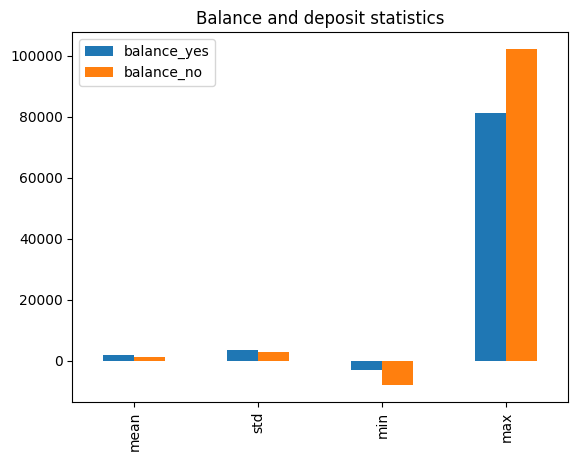

In [ ]:
b_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Balance and deposit statistics')

In [ ]:
#age and deposit

a_df = pd.DataFrame()
a_df['age_yes'] = (raw_data[raw_data['y'] == 'yes'][['y','age']].describe())['age']
a_df['age_no'] = (raw_data[raw_data['y'] == 'no'][['y','age']].describe())['age']

a_df

,age_yes,age_no
count,5289.000000,39922.000000
mean,41.670070,40.838986
std,13.497781,10.172662
min,18.000000,18.000000
25%,31.000000,33.000000
50%,38.000000,39.000000
75%,50.000000,48.000000
max,95.000000,95.000000


<Axes: title={'center': 'Age and deposit statistics'}>

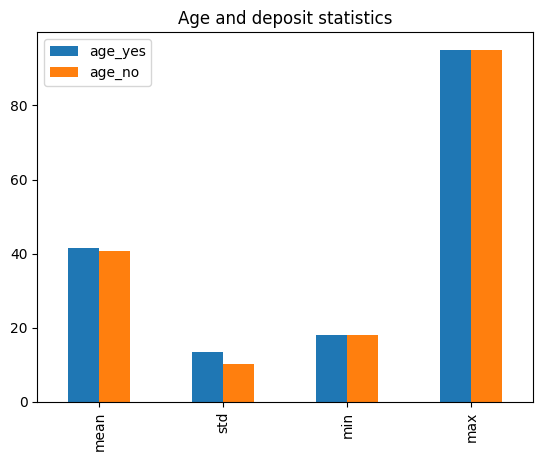

In [ ]:
a_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Age and deposit statistics')

In [ ]:
#number of contacts performed during this campaign ('campaign') and deposit
c_df = pd.DataFrame()
c_df['campaign_yes'] = (raw_data[raw_data['y'] == 'yes'][['y','campaign']].describe())['campaign']
c_df['campaign_no'] = (raw_data[raw_data['y'] == 'no'][['y','campaign']].describe())['campaign']

c_df

,campaign_yes,campaign_no
count,5289.000000,39922.000000
mean,2.141047,2.846350
std,1.921826,3.212767
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,3.000000,3.000000
max,32.000000,63.000000


<Axes: title={'center': 'Number of contacts performed during this campaign and deposit statistics'}>

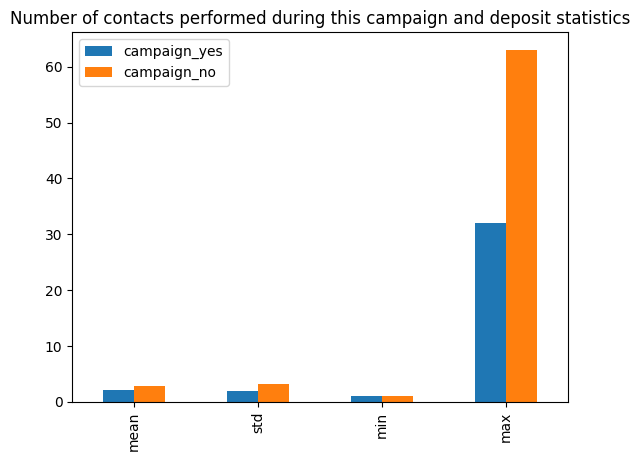

In [ ]:
c_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Number of contacts performed during this campaign and deposit statistics')

In [ ]:
#number of contacts performed during previous campaign ('previous') and deposit
p_df = pd.DataFrame()
p_df['previous_yes'] = (raw_data[raw_data['y'] == 'yes'][['y','previous']].describe())['previous']
p_df['previous_no'] = (raw_data[raw_data['y'] == 'no'][['y','previous']].describe())['previous']

p_df

,previous_yes,previous_no
count,5289.000000,39922.000000
mean,1.170354,0.502154
std,2.553272,2.256771
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,58.000000,275.000000


<Axes: title={'center': 'Number of contacts performed during previous campaign and deposit statistics'}>

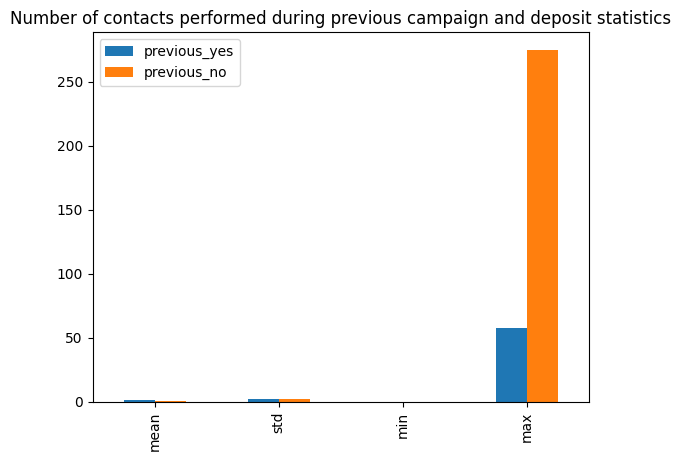

In [ ]:
p_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Number of contacts performed during previous campaign and deposit statistics')

Looking at the diagrams above we can conclude that:

People who subscribed for term deposit tend to have greater balance and age values.
People who subscribed for term deposit tend to have fewer number of contacts during this campaign.

#### [Table of Contents](#0.1)

### Categorical Variables

In [ ]:
categorical_features=[feature for feature in raw_data.columns if raw_data[feature].dtype=='O']
print('Number of Categorical Features:',len(categorical_features), '\n', categorical_features)
raw_data[categorical_features].head()

Number of Categorical Features: 10 
 ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


,job,marital,education,default,housing,loan,contact,month,poutcome,y
0,management,married,tertiary,no,yes,no,unknown,may,unknown,no
1,technician,single,secondary,no,yes,no,unknown,may,unknown,no
2,entrepreneur,married,secondary,no,yes,yes,unknown,may,unknown,no
3,blue-collar,married,unknown,no,yes,no,unknown,may,unknown,no
4,unknown,single,unknown,no,no,no,unknown,may,unknown,no


In [ ]:
for feature in categorical_features:
    print("{} number of unique categories in feature named {}".format(len(raw_data[feature].unique()),feature))

12 number of unique categories in feature named job
3 number of unique categories in feature named marital
4 number of unique categories in feature named education
2 number of unique categories in feature named default
2 number of unique categories in feature named housing
2 number of unique categories in feature named loan
3 number of unique categories in feature named contact
12 number of unique categories in feature named month
4 number of unique categories in feature named poutcome
2 number of unique categories in feature named y


In [ ]:
# Decide which categorical variables you want to use in model
for feature in raw_data.columns:
    if raw_data[feature].dtypes == 'object':# in pandas it is object
        unique_cat = len(raw_data[feature].unique())
        print("Feature '{feature}' has {unique_cat} unique categories".format(feature=feature, unique_cat=unique_cat))
        print(raw_data[feature].value_counts())
        print()

Feature 'job' has 12 unique categories
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

Feature 'marital' has 3 unique categories
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

Feature 'education' has 4 unique categories
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

Feature 'default' has 2 unique categories
no     44396
yes      815
Name: default, dtype: int64

Feature 'housing' has 2 unique categories
yes    25130
no     20081
Name: housing, dtype: int64

Feature 'loan' has 2 unique categories
no     37967
yes     7244
Name: loan, dtype: int64

Feature 'contact' has 3 unique categories
cellular     29285
unknown      13020
telephone     2906
Name: contac

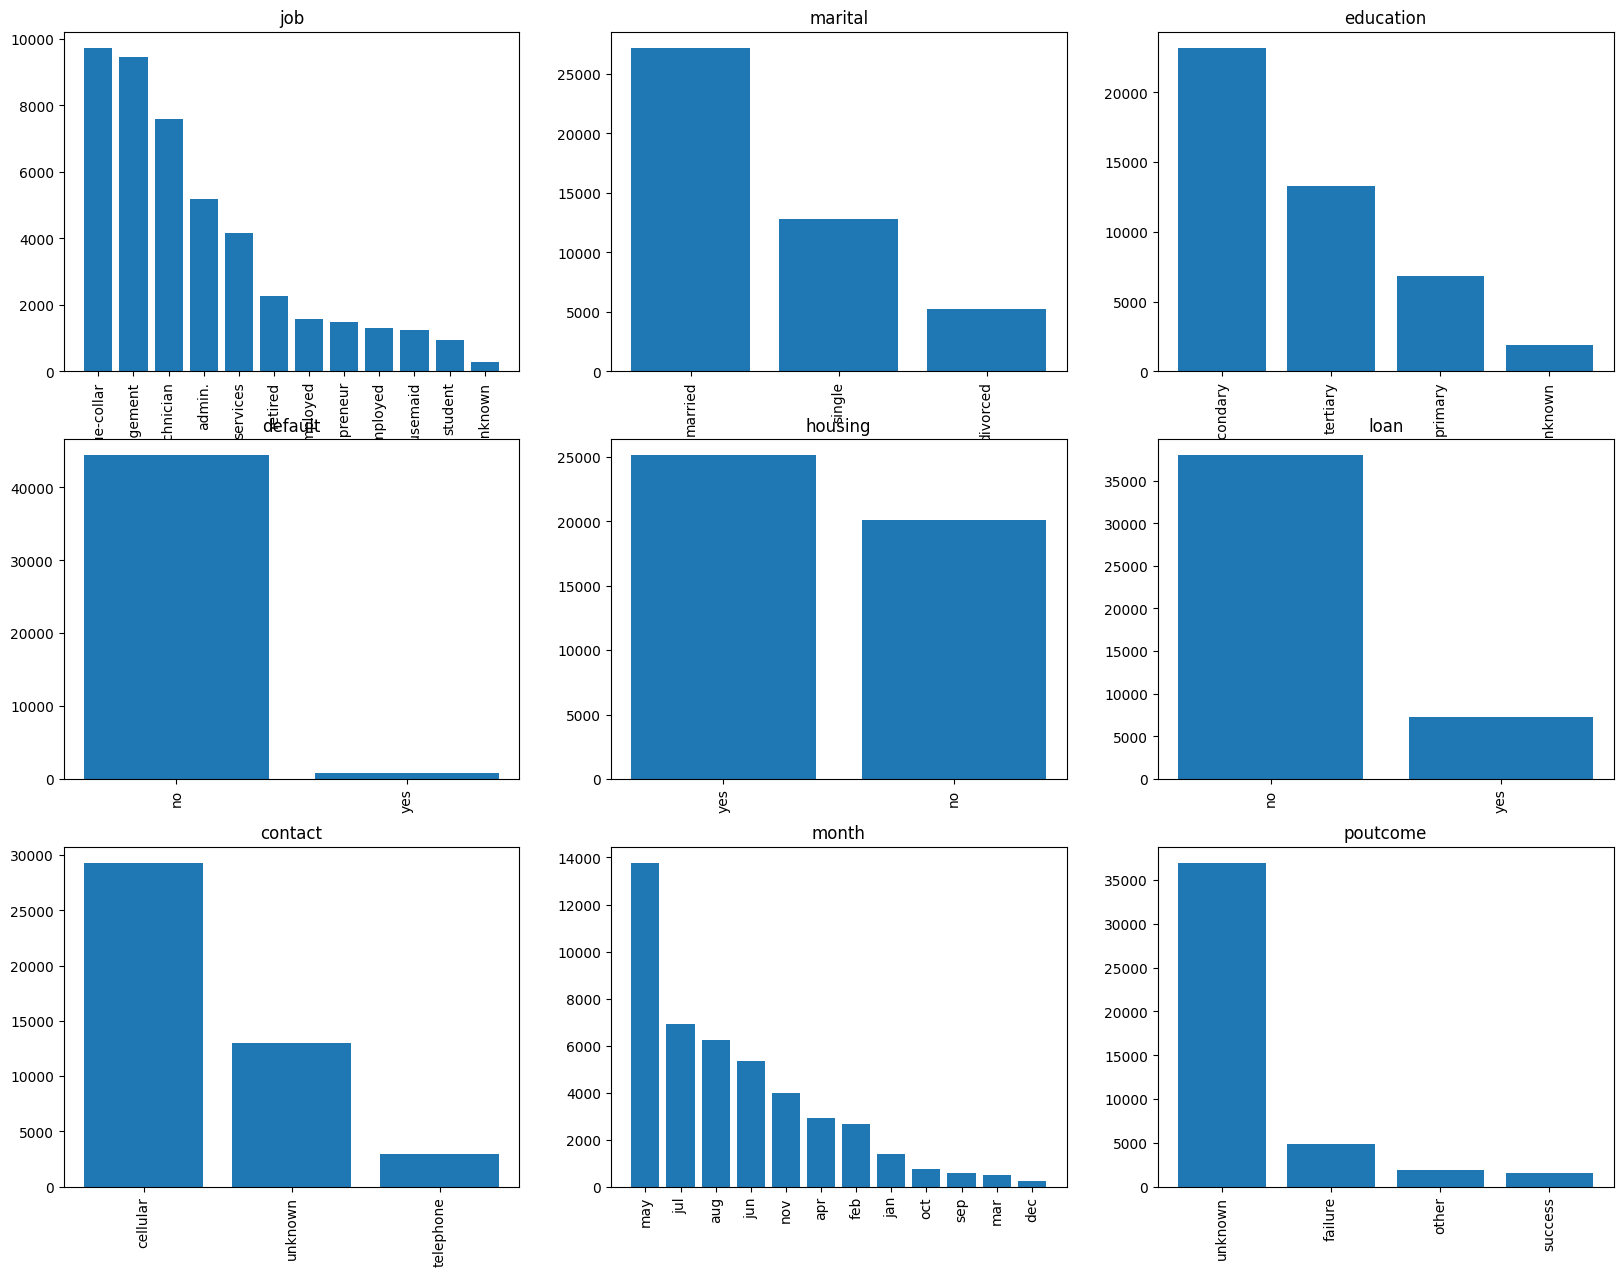

In [ ]:
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(20, 15))

counter = 0
for cat_column in cat_columns:
    value_counts = raw_data[cat_column].value_counts()

    trace_x = counter // 3
    trace_y = counter % 3
    x_pos = np.arange(0, len(value_counts))

    axs[trace_x, trace_y].bar(x_pos, value_counts.values, tick_label = value_counts.index)

    axs[trace_x, trace_y].set_title(cat_column)

    for tick in axs[trace_x, trace_y].get_xticklabels():
        tick.set_rotation(90)

    counter += 1

plt.show()

## [Table of Contents](#0.1)

### 3.5 Bar plot for all categorical variables in the dataset<a class="anchor" id="3.5"></a>

Text(0.5, 1.0, 'Jobs')

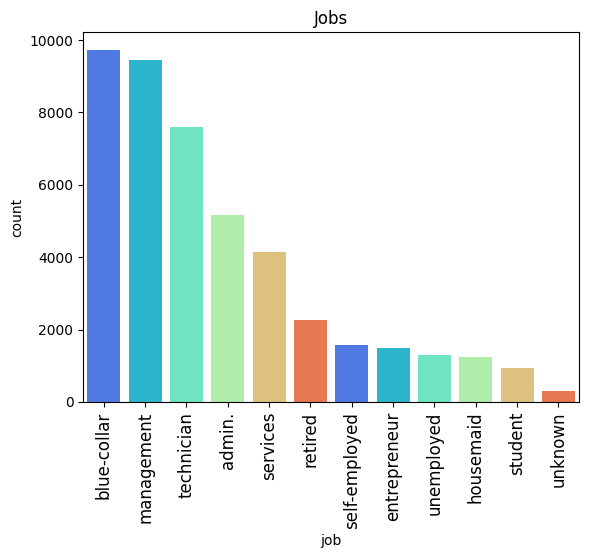

In [ ]:
pal = sns.color_palette('rainbow')
sns.countplot(x='job', data=raw_data, palette = pal,
              order=raw_data['job'].value_counts().index, );
plt.xticks(rotation = 90,fontsize = 12)
plt.title('Jobs')

Text(0.5, 1.0, 'Marital Status')

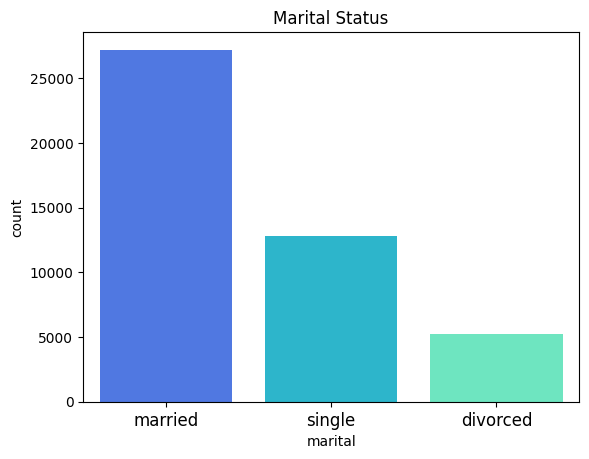

In [ ]:
sns.countplot(x='marital', data=raw_data, palette = pal,
              order=raw_data['marital'].value_counts().index)
plt.xticks(fontsize = 12)
plt.title('Marital Status')

Text(0.5, 1.0, 'Education')

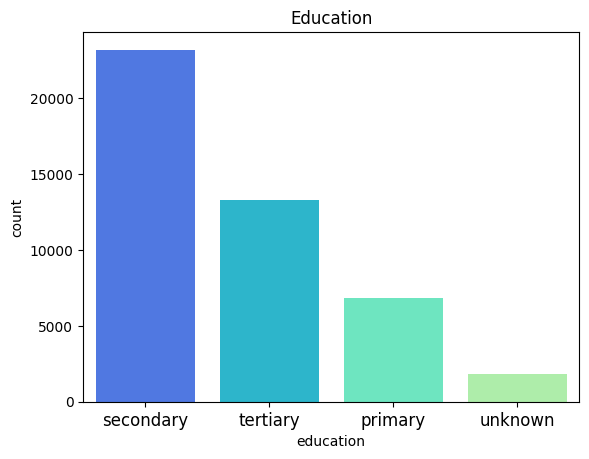

In [ ]:
sns.countplot(x='education', data=raw_data, palette = pal,
              order=raw_data['education'].value_counts().index)
plt.xticks(fontsize = 12)
plt.title('Education')

Text(0.5, 1.0, 'Housing')

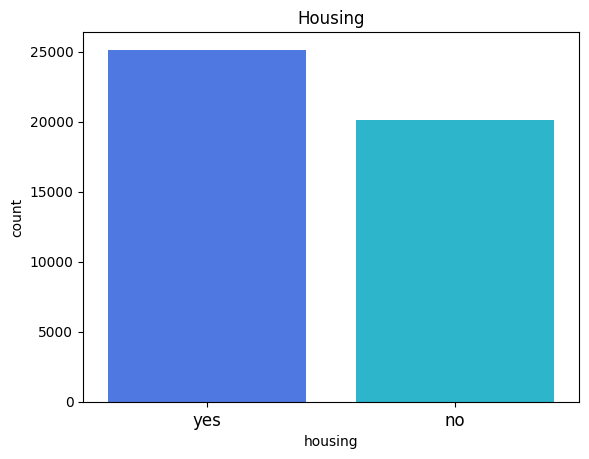

In [ ]:
sns.countplot(x='housing', data=raw_data, palette = pal,
              order=raw_data['housing'].value_counts().index)
plt.xticks(fontsize = 12)
plt.title('Housing')

Text(0.5, 1.0, 'Loan')

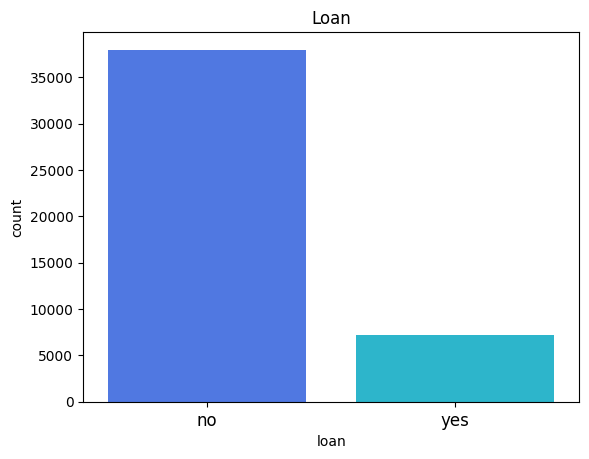

In [ ]:
sns.countplot(x='loan', data=raw_data, palette = pal,
              order=raw_data['loan'].value_counts().index)
plt.xticks(fontsize = 12)
plt.title('Loan')

### [Table of Contents](#0.1)

### 3.6 Analysis of the response column<a class="anchor" id="3.6"></a>
It is very important to look at the response column, which holds the information, which we are going to predict. In our case we should look at 'y' column and compare its values to other columns.
First of all we should look at the number of 'yes' and 'no' values in the response column 'y'.

#### Checking for Imbalanced or balanced dataset with regards to the Target

Imbalanced data refers to those types of datasets where the target class has an uneven distribution of observations, i.e one class label has a very high number of observations and the other has a very low number of observations.

Here, the class “No” is called the majority class, and the much smaller in size “Yes” class is called the minority class.

In [ ]:
countNotermdeposit = len(raw_data[raw_data.y == 'no'])
counthavetermdeposit = len(raw_data[raw_data.y == 'yes'])
print("Percentage of Customer doesn't have a term deposit: {:.2f}%".format((countNotermdeposit / (len(raw_data.y))*100)))
print("Percentage of Customer have a term deposit: {:.2f}%".format((counthavetermdeposit / (len(raw_data.y))*100)))

Percentage of Customer doesn't have a term deposit: 88.30%
Percentage of Customer have a term deposit: 11.70%


In [ ]:
raw_data.y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

Text(0.5, 1.0, 'Whether the client has subscribed a term deposit or not ')

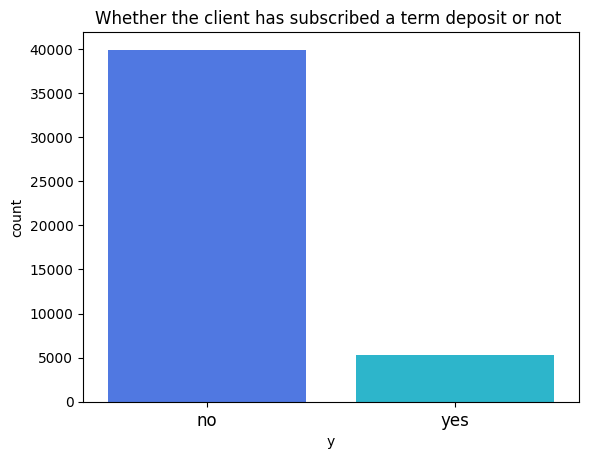

In [ ]:
sns.countplot(x='y', data=raw_data, palette = pal,
              order=raw_data['y'].value_counts().index)
plt.xticks(fontsize = 12)
plt.title('Whether the client has subscribed a term deposit or not ')

### Problems with imbalanced data classification
If we explain it in a very simple manner, the main problem with imbalanced dataset prediction is how accurately are we actually predicting both majority and minority class?

Sometimes when the records of a certain class are much more than the other class, our classifier may get biased towards the prediction. In this case, the confusion matrix for the classification problem shows how well our model classifies the target classes and we arrive at the accuracy of the model from the confusion matrix.

It is calculated based on the total no of correct predictions by the model divided by the total no of predictions. In the an example case it is (0+95)/(0+95+0+5)=0.95 or 95%. It means that the model fails to identify the minority class yet the accuracy score of the model will be 95%

Thus our traditional approach of classification and model accuracy calculation is not useful in the case of the imbalanced dataset

#### [Table of Contents](#0.1)

## 4. Data Visualization<a class="anchor" id="4"></a>

#### Analyzing the relationship of categorical features with respect to the Target feature

#### Univariate Analysis

<Axes: title={'center': 'Job and deposit'}>

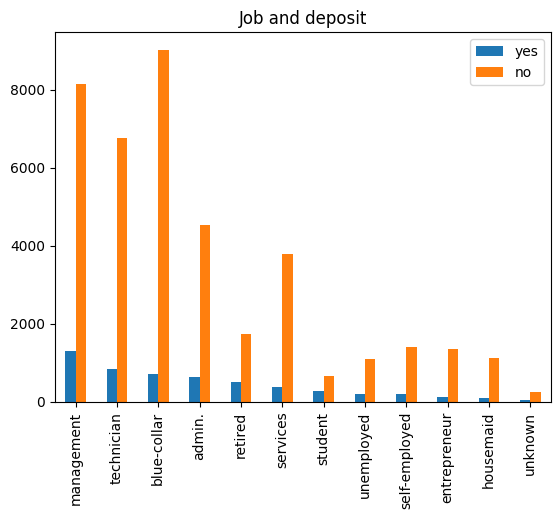

In [ ]:
#job and deposit
j_df = pd.DataFrame()

j_df['yes'] = raw_data[raw_data['y'] == 'yes']['job'].value_counts()
j_df['no'] = raw_data[raw_data['y'] == 'no']['job'].value_counts()

j_df.plot.bar(title = 'Job and deposit')

<Axes: xlabel='y', ylabel='job'>

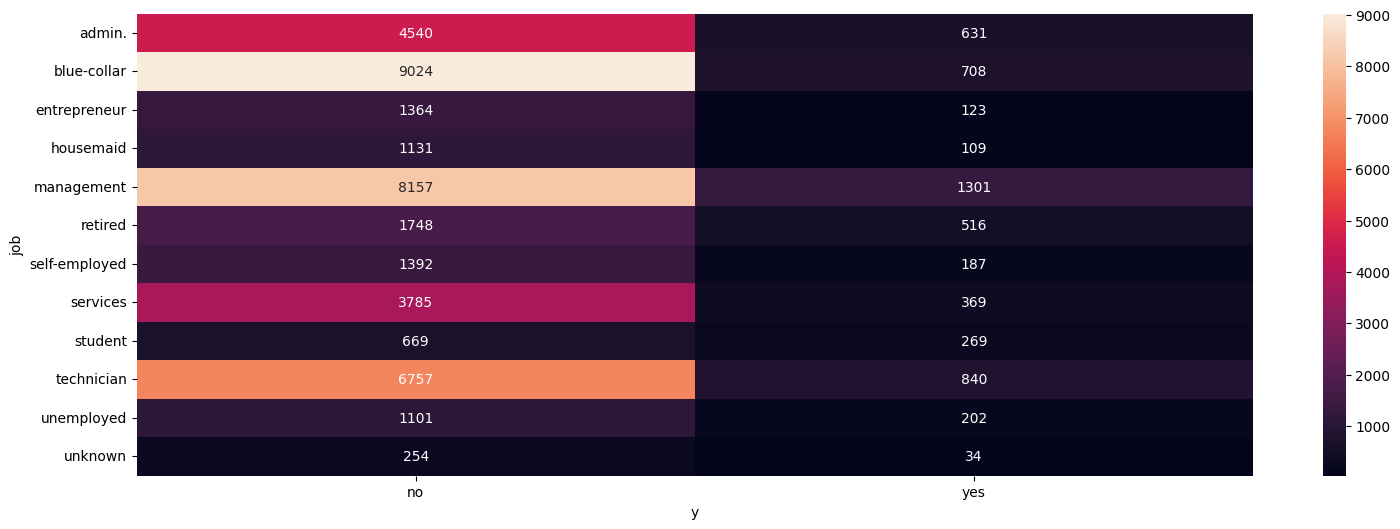

In [ ]:
fig= plt.figure(figsize=(18, 6))
sns.heatmap(pd.crosstab(index=raw_data['job'], columns=raw_data['y']), annot=True,
            fmt='g')

<Axes: title={'center': 'Marital status and deposit'}>

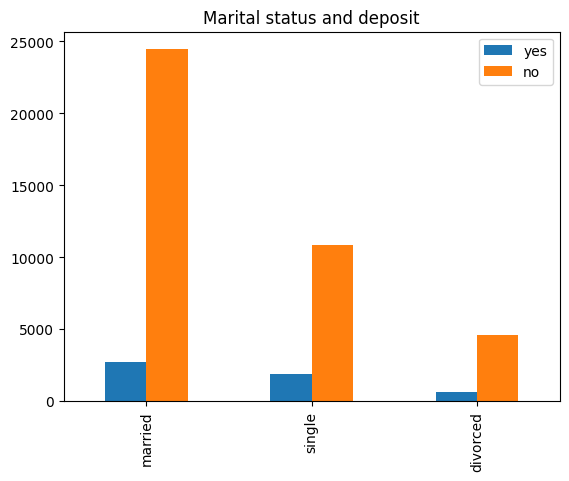

In [ ]:
#marital status and deposit
j_df = pd.DataFrame()

j_df['yes'] = raw_data[raw_data['y'] == 'yes']['marital'].value_counts()
j_df['no'] = raw_data[raw_data['y'] == 'no']['marital'].value_counts()

j_df.plot.bar(title = 'Marital status and deposit')

<Axes: xlabel='y', ylabel='marital'>

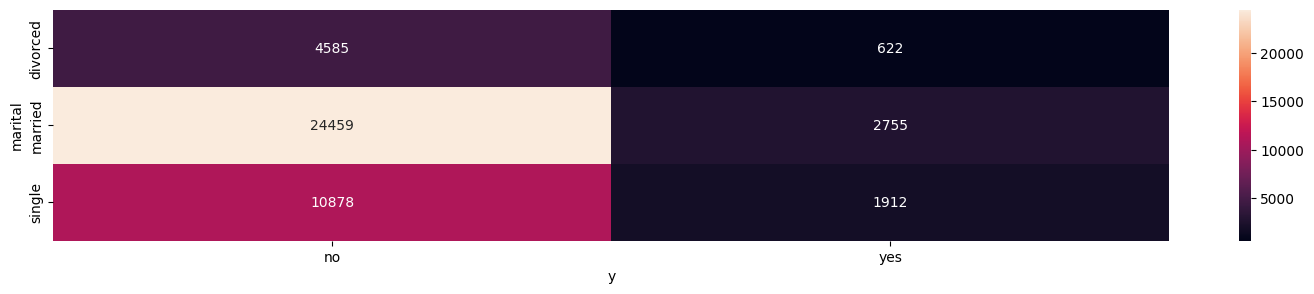

In [ ]:
fig= plt.figure(figsize=(18, 3))
sns.heatmap(pd.crosstab(index=raw_data['marital'], columns=raw_data['y']), annot=True,
            fmt='g')

<Axes: title={'center': 'Education and deposit'}>

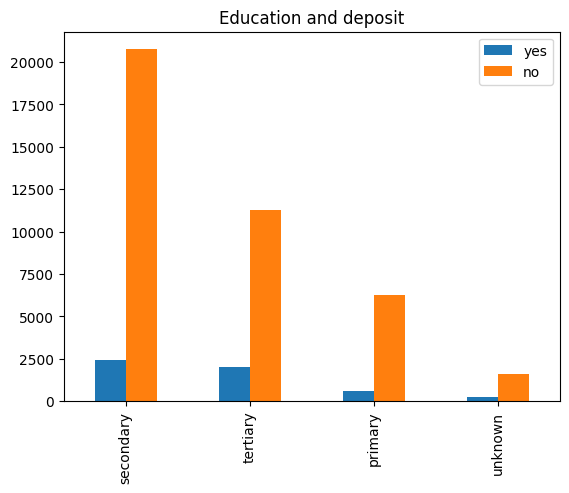

In [ ]:
#education and deposit
j_df = pd.DataFrame()

j_df['yes'] = raw_data[raw_data['y'] == 'yes']['education'].value_counts()
j_df['no'] = raw_data[raw_data['y'] == 'no']['education'].value_counts()

j_df.plot.bar(title = 'Education and deposit')

<Axes: xlabel='y', ylabel='education'>

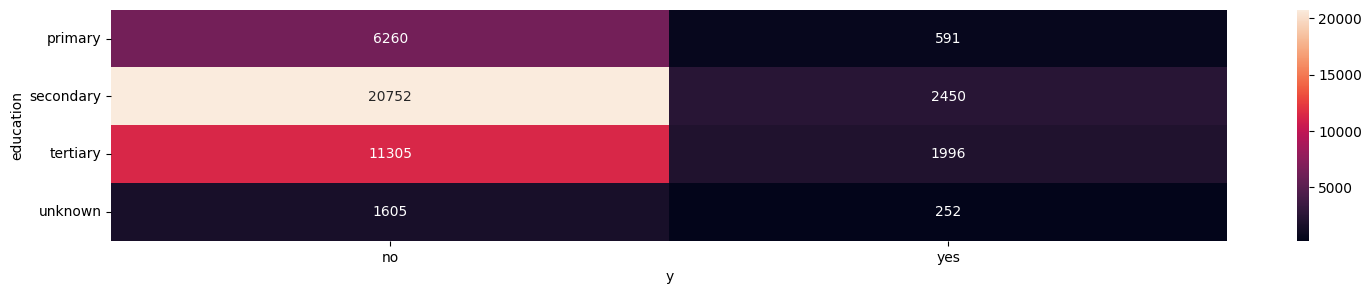

In [ ]:
fig= plt.figure(figsize=(18, 3))
sns.heatmap(pd.crosstab(index=raw_data['education'], columns=raw_data['y']), annot=True,
            fmt='g')

<Axes: title={'center': 'Type of contact and deposit'}>

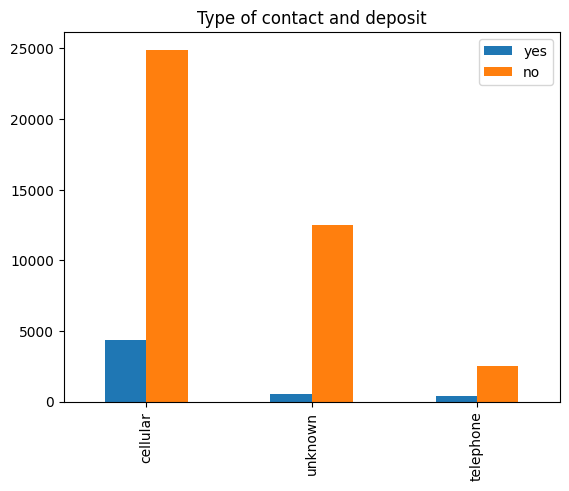

In [ ]:
#type of contact and deposit
j_df = pd.DataFrame()

j_df['yes'] = raw_data[raw_data['y'] == 'yes']['contact'].value_counts()
j_df['no'] = raw_data[raw_data['y'] == 'no']['contact'].value_counts()

j_df.plot.bar(title = 'Type of contact and deposit')

<Axes: xlabel='y', ylabel='contact'>

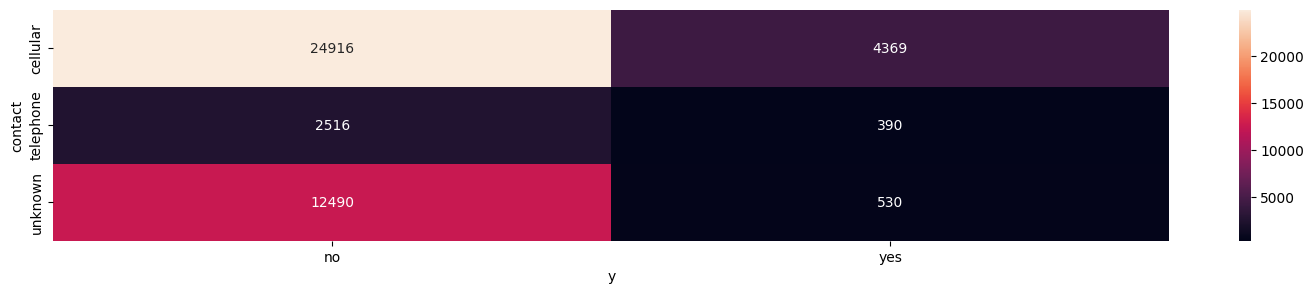

In [ ]:
fig= plt.figure(figsize=(18, 3))
sns.heatmap(pd.crosstab(index=raw_data['contact'], columns=raw_data['y']), annot=True,
            fmt='g')

<Axes: title={'center': 'Type of possible outcome and deposit'}>

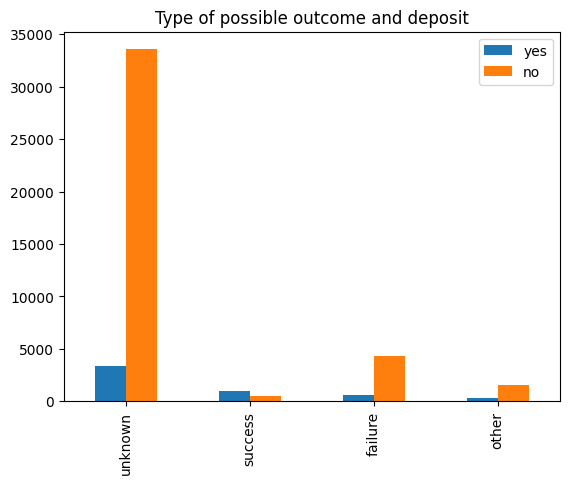

In [ ]:
#type of contact and deposit
j_df = pd.DataFrame()

j_df['yes'] = raw_data[raw_data['y'] == 'yes']['poutcome'].value_counts()
j_df['no'] = raw_data[raw_data['y'] == 'no']['poutcome'].value_counts()

j_df.plot.bar(title = 'Type of possible outcome and deposit')

<Axes: xlabel='y', ylabel='poutcome'>

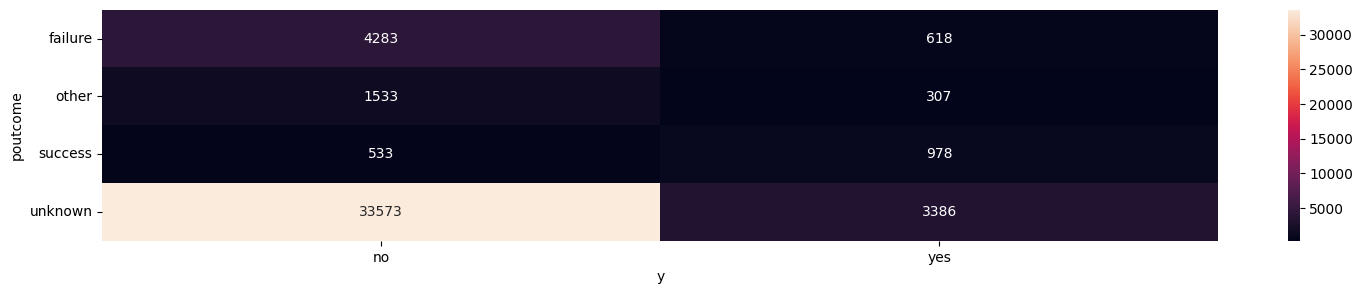

In [ ]:
fig= plt.figure(figsize=(18, 3))
sns.heatmap(pd.crosstab(index=raw_data['poutcome'], columns=raw_data['y']), annot=True,
            fmt='g')

<Axes: title={'center': 'Loan and deposit'}>

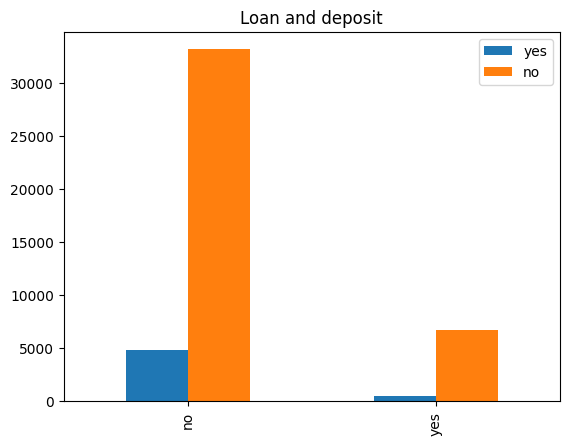

In [ ]:
#type of contact and deposit
j_df = pd.DataFrame()

j_df['yes'] = raw_data[raw_data['y'] == 'yes']['loan'].value_counts()
j_df['no'] = raw_data[raw_data['y'] == 'no']['loan'].value_counts()

j_df.plot.bar(title = 'Loan and deposit')

<Axes: xlabel='y', ylabel='loan'>

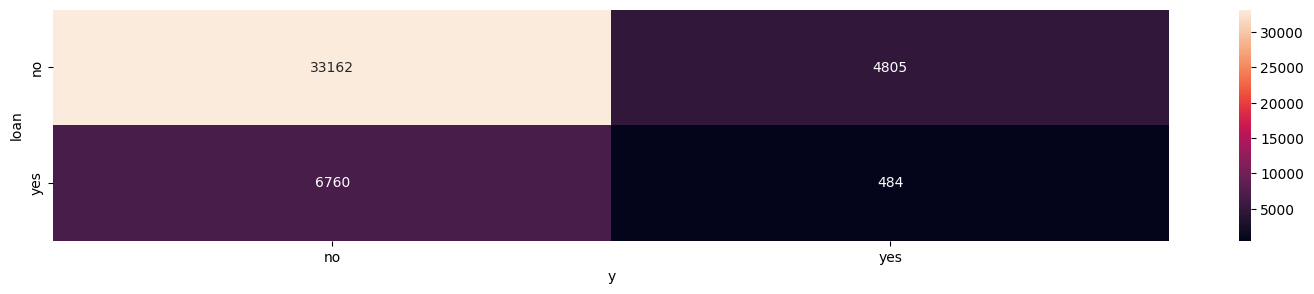

In [ ]:
fig= plt.figure(figsize=(18, 3))
sns.heatmap(pd.crosstab(index=raw_data['loan'], columns=raw_data['y']), annot=True,
            fmt='g')

Regarding the diagrams we can tell that according to our dataset:

Customers with 'blue-collar' and 'services' jobs are less likely to subscribe for term deposit.
Married customers are less likely to subscribe for term deposit.
Customers with 'cellular' type of contact are less likely to subscribe for term deposit.

#### [Table of Contents](#0.1)

### 4.1 Analyzing Relation by plotting Continuous features with the Target Feature<a class="anchor" id="4.1"></a>

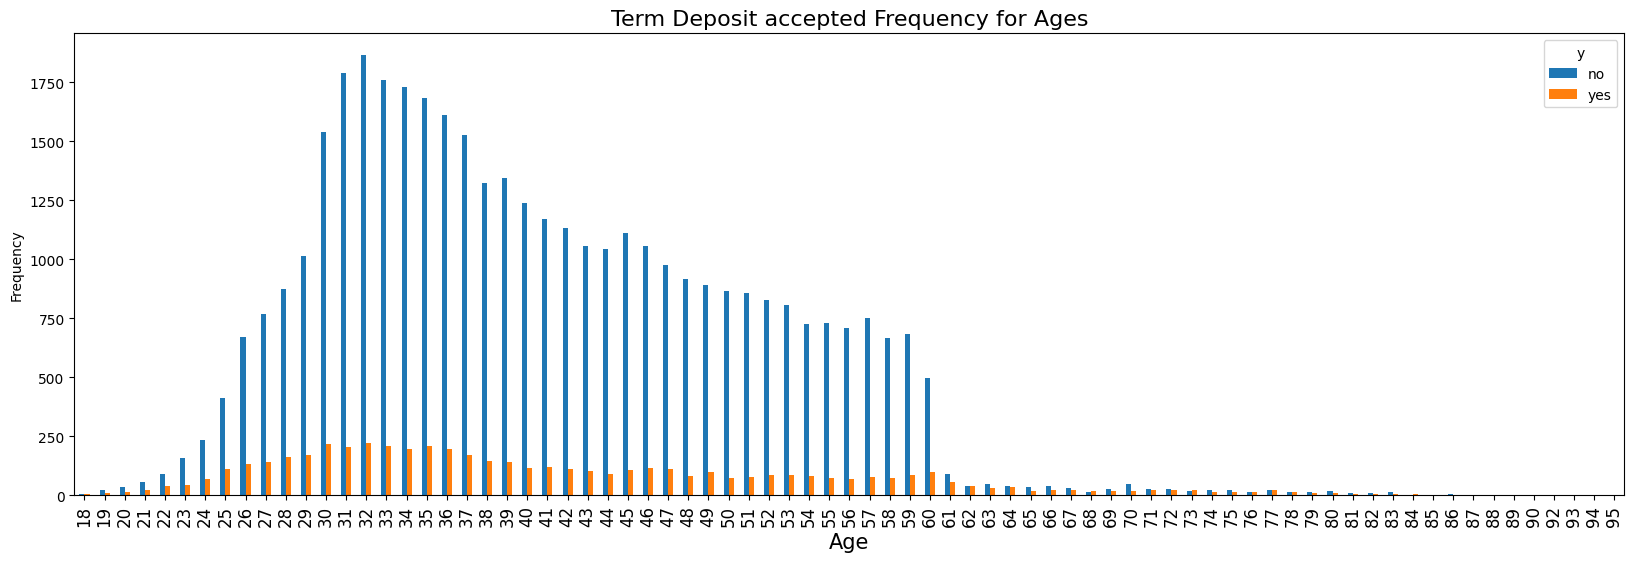

In [ ]:
pd.crosstab(raw_data.age,raw_data.y).plot(kind="bar",figsize=(20,6))
plt.title('Term Deposit accepted Frequency for Ages', fontsize = 16)
plt.xticks(fontsize = 12)
plt.xlabel('Age', fontsize = 15)
plt.ylabel('Frequency')
plt.show()

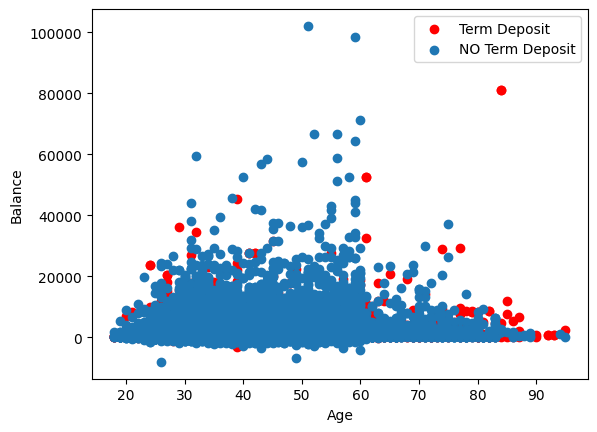

In [ ]:
plt.scatter(x=raw_data.age[raw_data.y== 'yes'], y=raw_data.balance[(raw_data.y== 'yes')], c="red")
plt.scatter(x=raw_data.age[raw_data.y== 'no'], y=raw_data.balance[(raw_data.y== 'no')])
plt.legend(["Term Deposit", "NO Term Deposit"])
plt.xlabel("Age")
plt.ylabel("Balance")
plt.show()

## [Table of Contents](#0.1)

### 4.2 Visualize the subscription and contact rate by age <a class="anchor" id="4.2"></a>

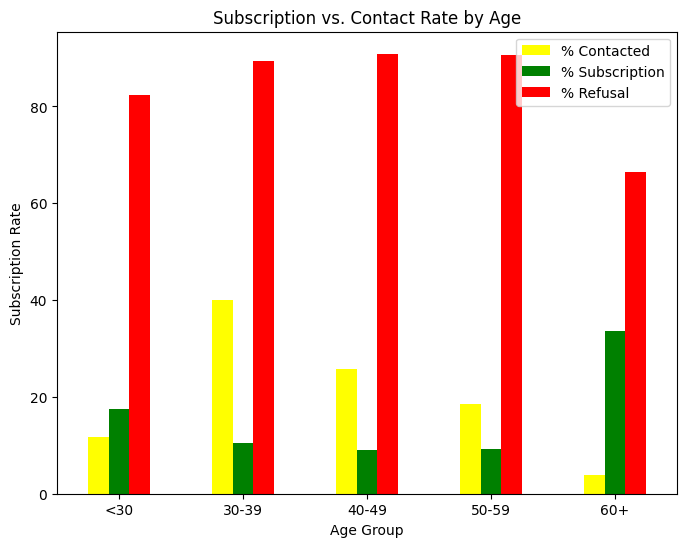

In [ ]:
lst = [raw_data]
for column in lst:
    column.loc[column["age"] < 30,  'age_group'] = 20
    column.loc[(column["age"] >= 30) & (column["age"] <= 39), 'age_group'] = 30
    column.loc[(column["age"] >= 40) & (column["age"] <= 49), 'age_group'] = 40
    column.loc[(column["age"] >= 50) & (column["age"] <= 59), 'age_group'] = 50
    column.loc[column["age"] >= 60, 'age_group'] = 60

count_age_response_pct = pd.crosstab(raw_data['y'],raw_data['age_group']).apply(lambda x: x/x.sum() * 100)
count_age_response_pct = count_age_response_pct.transpose()

age = pd.DataFrame(raw_data['age_group'].value_counts())
age['% Contacted'] = age['age_group']*100/age['age_group'].sum()
age['% Subscription'] = count_age_response_pct['yes']
age['% Refusal'] = count_age_response_pct['no']
age.drop('age_group',axis = 1,inplace = True)

age['age'] = [30,40,50,20,60]
age = age.sort_values('age',ascending = True)

plot_age = age[['% Contacted','% Subscription','% Refusal']].plot(kind = 'bar',
                                              figsize=(8,6), color = ('yellow','green','red'))
plt.xlabel('Age Group')
plt.ylabel('Subscription Rate')
plt.xticks(np.arange(5), ('<30', '30-39', '40-49', '50-59', '60+'),rotation = 'horizontal')
plt.title('Subscription vs. Contact Rate by Age')
plt.show()

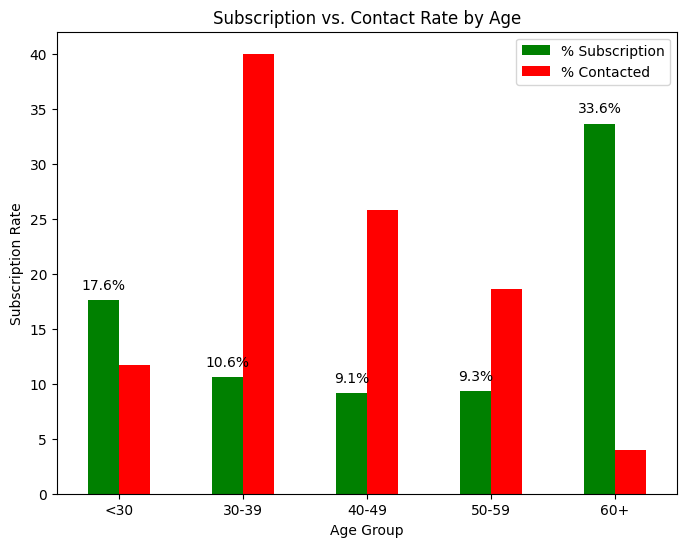

In [ ]:
lst = [raw_data]
for column in lst:
    column.loc[column["age"] < 30,  'age_group'] = 20
    column.loc[(column["age"] >= 30) & (column["age"] <= 39), 'age_group'] = 30
    column.loc[(column["age"] >= 40) & (column["age"] <= 49), 'age_group'] = 40
    column.loc[(column["age"] >= 50) & (column["age"] <= 59), 'age_group'] = 50
    column.loc[column["age"] >= 60, 'age_group'] = 60

count_age_response_pct = pd.crosstab(raw_data['y'],raw_data['age_group']).apply(lambda x: x/x.sum() * 100)
count_age_response_pct = count_age_response_pct.transpose()

age = pd.DataFrame(raw_data['age_group'].value_counts())
age['% Contacted'] = age['age_group']*100/age['age_group'].sum()
age['% Subscription'] = count_age_response_pct['yes']
age.drop('age_group',axis = 1,inplace = True)

age['age'] = [30,40,50,20,60]
age = age.sort_values('age',ascending = True)

plot_age = age[['% Subscription','% Contacted']].plot(kind = 'bar',
                                              figsize=(8,6), color = ('green','red'))
plt.xlabel('Age Group')
plt.ylabel('Subscription Rate')
plt.xticks(np.arange(5), ('<30', '30-39', '40-49', '50-59', '60+'),rotation = 'horizontal')
plt.title('Subscription vs. Contact Rate by Age')

# label the bar
for rec, label in zip(plot_age.patches,
                      age['% Subscription'].round(1).astype(str)):
    plot_age.text(rec.get_x() + rec.get_width()/2,
                      rec.get_height() + 1,
                      label+'%',
                      ha = 'center',
                      color = 'black')

+ Insights: target the youngest and the oldest instead of the middle-aged

Green vertical bars indicate that clients with a age of 60+ have the highest subscription rate. About 17% of the subscriptions came from the clients aged between 18 to 29. More than 50% of the subscriptions are contributed by the youngest and the eldest clients.

### 4.3 Visualize the subscription rate by balance level<a class="anchor" id="4.3"></a>

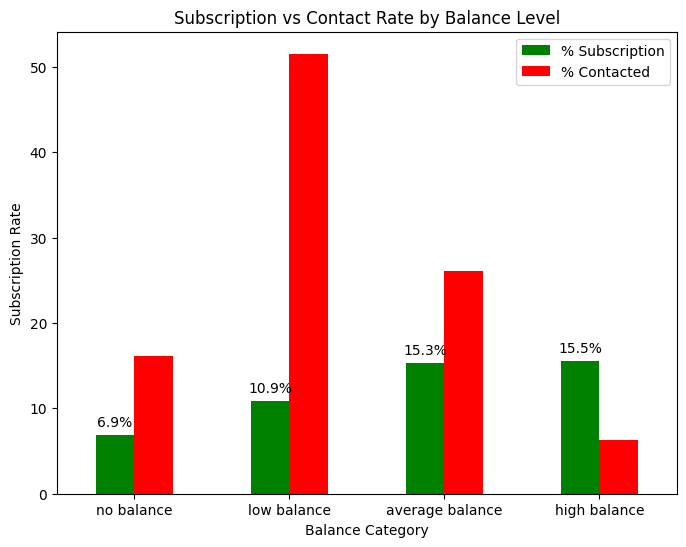

In [ ]:
lst = [raw_data]
for column in lst:
    column.loc[column["balance"] <= 0,  'balance_group'] = 'no balance'
    column.loc[(column["balance"] > 0) & (column["balance"] <= 1000), 'balance_group'] = 'low balance'
    column.loc[(column["balance"] > 1000) & (column["balance"] <= 5000), 'balance_group'] = 'average balance'
    column.loc[(column["balance"] > 5000), 'balance_group'] = 'high balance'

count_balance_response_pct = pd.crosstab(raw_data['y'],raw_data['balance_group']).apply(lambda x: x/x.sum() * 100)
count_balance_response_pct = count_balance_response_pct.transpose()

bal = pd.DataFrame(raw_data['balance_group'].value_counts())
bal['% Contacted'] = bal['balance_group']*100/bal['balance_group'].sum()
bal['% Subscription'] = count_balance_response_pct['yes']
bal.drop('balance_group',axis = 1,inplace = True)

bal['bal'] = [1,2,0,3]
bal = bal.sort_values('bal',ascending = True)

plot_balance = bal[['% Subscription','% Contacted']].plot(kind = 'bar',
                                               color = ('green','red'),
                                               figsize = (8,6))

plt.title('Subscription vs Contact Rate by Balance Level')
plt.ylabel('Subscription Rate')
plt.xlabel('Balance Category')
plt.xticks(rotation = 'horizontal')

# label the bar
for rec, label in zip(plot_balance.patches,
                      bal['% Subscription'].round(1).astype(str)):
    plot_balance.text(rec.get_x() + rec.get_width()/2,
                      rec.get_height() + 1,
                      label+'%',
                      ha = 'center',
                      color = 'black')

Insights: target clients with average or high balance

To identify the trend more easily, clients are categorized into four groups based on their levels of balance:

+ No Balance: clients with a negative balance.
+ Low Balance: clients with a balance between 0 and 1000 euros
+ Average Balance: clients with a balance between 1000 and 5000 euros.
+ High Balance: clients with a balance greater than 5000 euros.

Unsurprisingly, this bar chart indicates a positive correlation between clients’ balance levels and subscription rate. Clients with negative balances only returned a subscription rate of 6.9% while clients with average or high balances had significantly higher subscription rates, nearly 15%.

However, in this campaign, more than 50% of clients contacted only have a low balance level. In the future, the bank should shift its marketing focus to high-balance customers to secure more term deposits.

## [Table of Content](#0.1)

### 4.4 Visualize the subscription rate by age and balance<a class="anchor" id="4.4"></a>

In [ ]:
# Step 1: Change column name: 'y' to 'response'
df  =raw_data.copy()
df.rename(index=str, columns={'y': 'response'}, inplace = True)

def convert(data, new_column, old_column):
    data[new_column] = data[old_column].apply(lambda x: 0 if x == 'no' else 1)
    return data[new_column].value_counts()

convert(df, "response_binary", "response")

0    39922
1     5289
Name: response_binary, dtype: int64

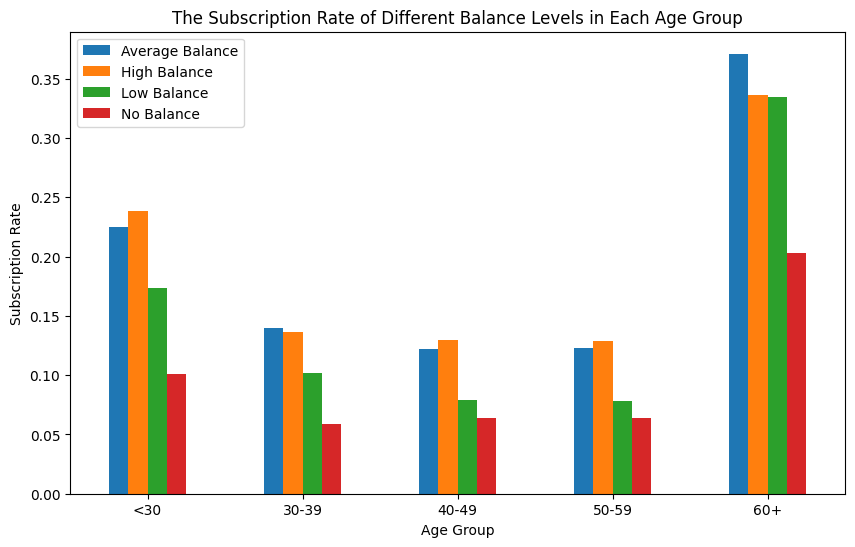

In [ ]:
age_balance1 = pd.DataFrame(df.groupby(['age_group','balance_group'])['response_binary'].sum())
age_balance2 = pd.DataFrame(df.groupby(['age_group','balance_group'])['response'].count())

age_balance1['response'] = age_balance2['response']
age_balance1['response_rate'] = age_balance1['response_binary']/ (age_balance1['response'])
age_balance1 = age_balance1.drop(['response_binary','response'],axis =1)

age_balance1 = age_balance1.unstack()
age_bal = age_balance1.plot(kind='bar',figsize = (10,6))

# Set x ticks
plt.xticks(np.arange(5),('<30', '30-39', '40-49', '50-59', '60+'),rotation = 'horizontal')

# Set legend
plt.legend(['Average Balance','High Balance','Low Balance','No Balance'],loc = 'best',ncol = 1)

plt.ylabel('Subscription Rate')
plt.xlabel('Age Group')
plt.title('The Subscription Rate of Different Balance Levels in Each Age Group')
plt.show()

<b>Insights: target older clients with high balance levels</b>

While age represents a person’s life stage and balance represents a person’s financial condition, jointly evaluating the impact of these two factors enables us to investigate if there is a common trend across all ages, and to identify which combination of client features indicates the highest likelihood of subscription.

In order to investigate the combined effect of age and balance on a client’s decision, we performed a two-layer grouping, segmenting customers according to their balance levels within each age group.

+ The graph tells the same story regarding the subscription rate for different age groups: <b>the willingness to subscribe is exceptionally high for people aged above 60 and younger people aged below 30</b> also have a distinguishable higher subscription rate than those of other age groups.
    
+ Furthermore, <b>the effect of balance levels on subscription decision is applicable to each individual age group:</b> every age group shares a common trend that the percentage of subscription increases with balance.

In sum, the bank should <b>prioritize its telemarketing to clients who are above 60 years old and have positive balances</b>, because they have the highest acceptance rate of about 35%. The next group the bank should focus on is <b>young clients with positive balances</b>, who showed high subscription rates between 15% and 20%.

### 4.5 Visualize the subscription rate by job<a class="anchor" id="4.5"></a>

In [ ]:
count_job_response_pct = pd.crosstab(df['response'],df['job']).apply(lambda x: x/x.sum() * 100)
count_job_response_pct

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
response,,,,,,,,,,,,
no,87.797331,92.725031,91.728312,91.209677,86.244449,77.208481,88.157061,91.116996,71.321962,88.943004,84.497314,88.194444
yes,12.202669,7.274969,8.271688,8.790323,13.755551,22.791519,11.842939,8.883004,28.678038,11.056996,15.502686,11.805556


In [ ]:
count_job_response_pct = count_job_response_pct.transpose()
count_job_response_pct

response,no,yes
job,,
admin.,87.797331,12.202669
blue-collar,92.725031,7.274969
entrepreneur,91.728312,8.271688
housemaid,91.209677,8.790323
management,86.244449,13.755551
retired,77.208481,22.791519
self-employed,88.157061,11.842939
services,91.116996,8.883004
student,71.321962,28.678038


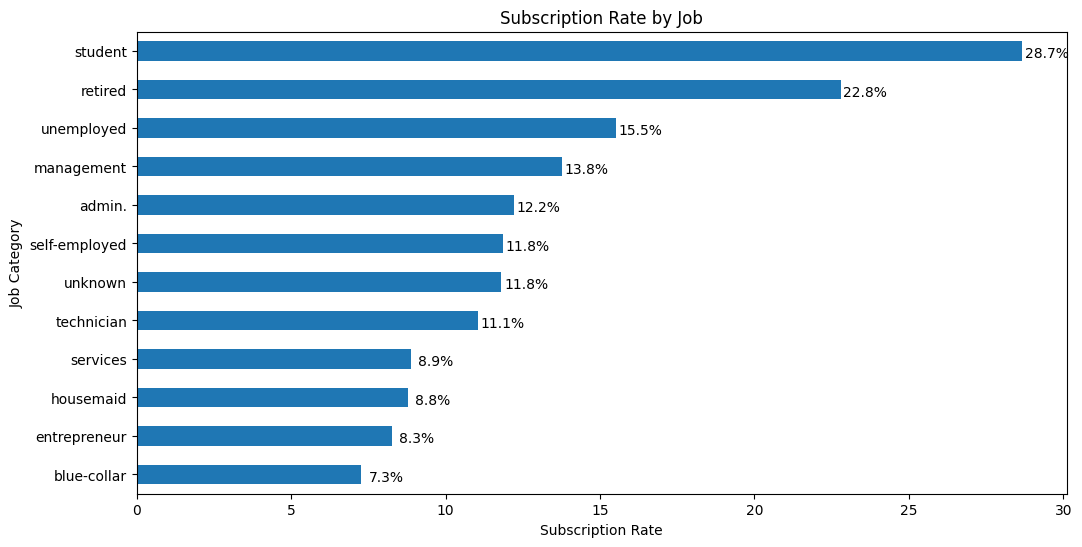

In [ ]:
plot_job = count_job_response_pct['yes'].sort_values(ascending = True).plot(kind ='barh',
                                                                           figsize = (12,6))

plt.title('Subscription Rate by Job')
plt.xlabel('Subscription Rate')
plt.ylabel('Job Category')

# Label each bar
for rec, label in zip(plot_job.patches,
                      count_job_response_pct['yes'].sort_values(ascending = True).round(1).astype(str)):
    plot_job.text(rec.get_width()+0.8,
                  rec.get_y()+ rec.get_height()-0.5,
                  label+'%',
                  ha = 'center',
                  va='bottom')

<b>Insights: target students and retired clients

As noted from the horizontal bar chart, students and retired clients account have more than 50% of subscription, which is consistent with the previous finding of higher subscription rates among the younger and older.

### 4.6 Visualize the relationship between 'duration' & 'campaign': with response result<a class="anchor" id="4.6"></a>

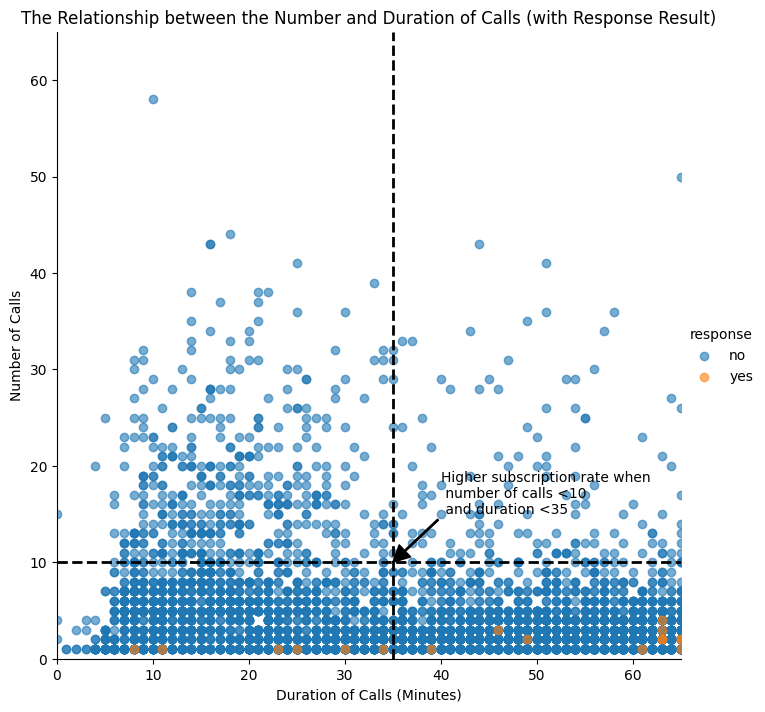

In [ ]:
dur_cam = sns.lmplot(x='duration', y='campaign', data=df,
                     hue = 'response',
                     fit_reg=False,
                     scatter_kws={'alpha': 0.6}, height=7)

# Add plot elements
plt.axis([0, 65, 0, 65])
plt.ylabel('Number of Calls')
plt.xlabel('Duration of Calls (Minutes)')
plt.title('The Relationship between the Number and Duration of Calls (with Response Result)')

# Add annotations
plt.axhline(y=10, linewidth=2, color="k", linestyle='--')
plt.axvline(x=35, linewidth=2, color="k", linestyle='--')
plt.annotate("Higher subscription rate when \n number of calls <10 \n and duration <35", xytext=(40, 15),
             arrowprops=dict(color='k', width=1), xy=(35, 10))
plt.show()

In this scatter plot, clients subscribed to term deposits are denoted as "yes" while those did not are denoted as "no".

As we can see from the plot, “yes” clients and “no” clients are forming two relatively separate clusters. Compared to “no” clients”, “yes” clients were contacted by fewer times and had longer call duration. More importantly, after 6 campaign calls, clients are more likely to reject the term deposit unless the duration is high. Most “yes” clients were approached by less than 10 times.

This suggests that the bank should resist calling a client for more than five times, which can be disturbing and increase dissatisfaction.

### 4.7 Visualize the subscription and contact rate by month<a class="anchor" id="4.7"></a>

TypeError: can only concatenate str (not "float") to str

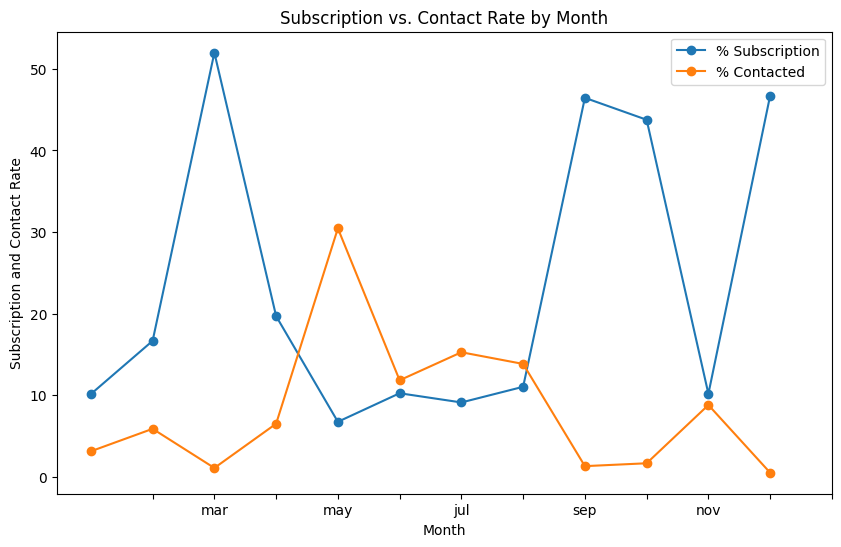

In [ ]:
# Step 4: Change 'month' from words to numbers for easier analysis
order={'month':{'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}}
df1=df1.replace(order)

count_month_response_pct = pd.crosstab(df['response'],df['month']).apply(lambda x: x/x.sum() * 100)
count_month_response_pct = count_month_response_pct.transpose()
month = pd.DataFrame(df['month'].value_counts())
month['% Contacted'] = month['month']*100/month['month'].sum()
month['% Subscription'] = count_month_response_pct['yes']
month.drop('month',axis = 1,inplace = True)

month['Month'] = [5,7,8,6,11,4,2,1,10,9,3,12]
month = month.sort_values('Month',ascending = True)
plot_month = month[['% Subscription','% Contacted']].plot(kind ='line',
                                                          figsize = (10,6),
                                                          marker = 'o')

plt.title('Subscription vs. Contact Rate by Month')
plt.ylabel('Subscription and Contact Rate')
plt.xlabel('Month')

ticks = np.arange(1,13,1)
plt.xticks(ticks)

# Annotation: peak of contact
y = month['% Contacted'].max()
x = month['% Contacted'].idxmax()
plt.annotate('May: Peak of contact', xy=(x+0.1, y+0.1), xytext=(x+1,y+4), arrowprops=dict(facecolor='black', headwidth=6, width=1, headlength=4), horizontalalignment='left', verticalalignment='top')

# Annotation: peak of subscription rate
y = month['% Subscription'].max()
x = month['% Subscription'].idxmax()
plt.annotate('March: Peak Subscription rate', xy=(x+0.1, y+0.1), xytext=(x+1,y+1), arrowprops=dict(facecolor='black', headwidth=6, width=1, headlength=4), horizontalalignment='left', verticalalignment='top')

plt.show()

TypeError: can only concatenate str (not "float") to str

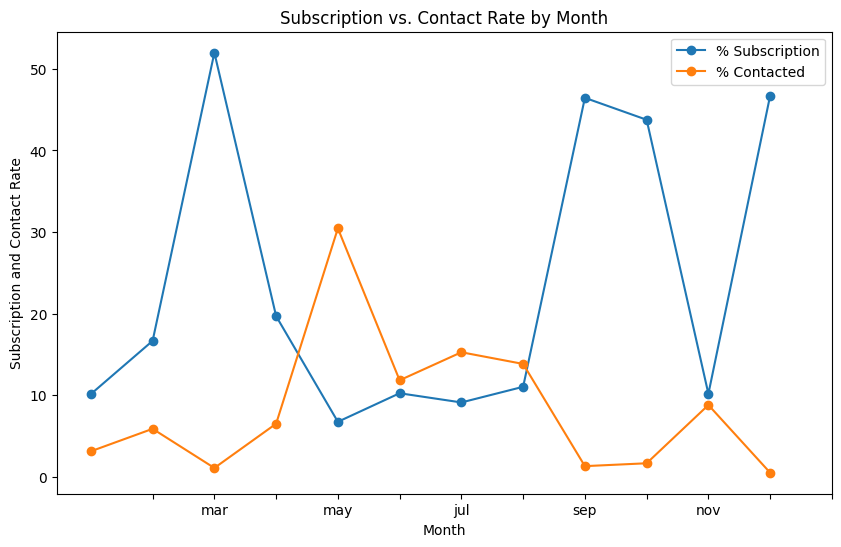

In [ ]:
# Step 4: Change 'month' from words to numbers for easier analysis
order={'month':{'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}}
df1=df1.replace(order)

count_month_response_pct = pd.crosstab(df['response'],df['month']).apply(lambda x: x/x.sum() * 100)
count_month_response_pct = count_month_response_pct.transpose()
month = pd.DataFrame(df['month'].value_counts())
month['% Contacted'] = month['month']*100/month['month'].sum()
month['% Subscription'] = count_month_response_pct['yes']
month.drop('month',axis = 1,inplace = True)

month['Month'] = [5,7,8,6,11,4,2,1,10,9,3,12]
month = month.sort_values('Month',ascending = True)
plot_month = month[['% Subscription','% Contacted']].plot(kind ='line',
                                                          figsize = (10,6),
                                                          marker = 'o')

plt.title('Subscription vs. Contact Rate by Month')
plt.ylabel('Subscription and Contact Rate')
plt.xlabel('Month')

ticks = np.arange(1,13,1)
plt.xticks(ticks)

# Annotation: peak of contact
y = month['% Contacted'].max()
x = month['% Contacted'].idxmax()
plt.annotate('May: Peak of contact', xy=(x+0.1, y+0.1), xytext=(x+1,y+4), arrowprops=dict(facecolor='black', headwidth=6, width=1, headlength=4), horizontalalignment='left', verticalalignment='top')

# Annotation: peak of subscription rate
y = month['% Subscription'].max()
x = month['% Subscription'].idxmax()
plt.annotate('March: Peak Subscription rate', xy=(x+0.1, y+0.1), xytext=(x+1,y+1), arrowprops=dict(facecolor='black', headwidth=6, width=1, headlength=4), horizontalalignment='left', verticalalignment='top')

plt.show()

<b>Insights: initiate the telemarketing campaign in fall or spring</b>

Besides customer characteristics, external factors may also have an impact on the subscription rate, such as seasons and the time of calling. So the month of contact is also analyzed here.

This line chart displays the bank’s contact rate in each month as well as clients’ response rate in each month. One way to evaluate the effectiveness of the bank's marketing plan is to see whether these two lines have a similar trend over the same time horizon.

+ The bank contacted most clients between May and August. The highest contact rate is around 30%, which happened in May, while the contact rate is closer to 0 in March, September, October, and December.


+ However, the subscription rate showed a different trend. The highest subscription rate occurred in March, which is over 50%, and all subscription rates in September, October, and December are over 40%.


Clearly, these two lines move in different directions which strongly indicates the inappropriate timing of the bank’s marketing campaign. To improve the marketing campaign, the bank should consider initiating the telemarketing campaign in fall and spring when the subscription rate tends to be higher.

Nevertheless, the bank should be cautious when analyzing external factors. More data from previous marketing campaign should be collected and analyzed to make sure that this seasonal effect is constant over time and applicable to the future.

#### Visualize the subscription rate by Education

In [ ]:
df.education.unique()

array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object)

In [ ]:
count_education_response_pct = pd.crosstab(df['response'],df['education']).apply(lambda x: x/x.sum() * 100)
count_education_response_pct = count_education_response_pct.transpose()
count_education_response_pct

response,no,yes
education,,
primary,91.373522,8.626478
secondary,89.440565,10.559435
tertiary,84.993610,15.006390
unknown,86.429725,13.570275


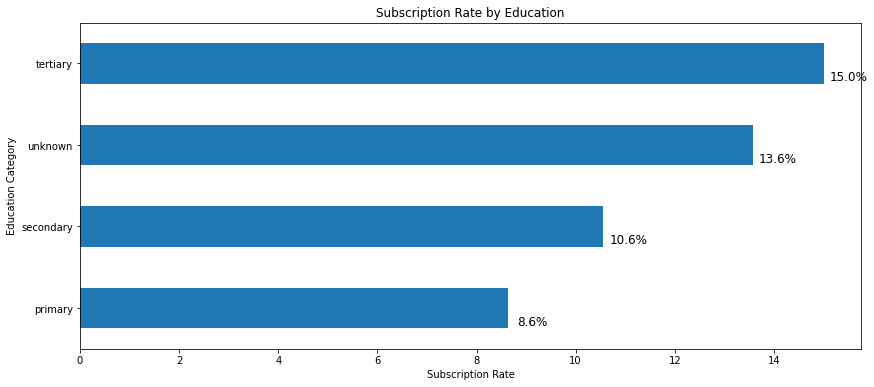

In [ ]:
plot_education = count_education_response_pct['yes'].sort_values(ascending = True).plot(kind ='barh',
                                                                           figsize = (14,6))

plt.title('Subscription Rate by Education')
plt.xlabel('Subscription Rate')
plt.ylabel('Education Category')

# Label each bar
for rec, label in zip(plot_education.patches,
                      count_education_response_pct['yes'].sort_values(ascending = True).round(1).astype(str)):
    plot_education.text(rec.get_width()+0.5,
                  rec.get_y()+ rec.get_height()-0.5,
                  label+'%',
                  ha = 'center',
                  va='bottom',
                fontsize = 'large')

#### [Table of Content](#0.1)

## 5. Clean the dataset <a class="anchor" id="5"></a>
#### Deal with missing data
There is no missing value in this dataset. Nevertheless, there are values like “unknown”, “others”, which are helpless just like missing values. Thus, these ambiguous values are removed from the dataset.

![FilterMethods](https://www.geeksforgeeks.org/wp-content/uploads/ml.png)

#### 'Unkown' values were found in some of the features
+ We need to handle those values

In [ ]:
cols = [col for col in raw_data.columns]
col_missing = []
for col in cols:
    if 'unknown' in raw_data[col].values:
        col_missing.append(col)

print("Columns with Unknown Values -",col_missing)

Columns with Unknown Values - ['job', 'education', 'contact', 'poutcome']


In [ ]:
print("Unknown values count")
for col in col_missing:
    print(col,"-",raw_data[raw_data[col].str.contains('unknown')][col].count())

Unknown values count
job - 288
education - 1857
contact - 13020
poutcome - 36959


In [ ]:
print(raw_data.groupby(raw_data['job'])['job'].count(),"\n")

job
admin.           5171
blue-collar      9732
entrepreneur     1487
housemaid        1240
management       9458
retired          2264
self-employed    1579
services         4154
student           938
technician       7597
unemployed       1303
unknown           288
Name: job, dtype: int64 



In [ ]:
print(raw_data.groupby(raw_data['education'])['education'].count(),"\n")

education
primary       6851
secondary    23202
tertiary     13301
unknown       1857
Name: education, dtype: int64 



In [ ]:
print(raw_data.groupby(raw_data['poutcome'])['poutcome'].count(),"\n")

poutcome
failure     4901
other       1840
success     1511
unknown    36959
Name: poutcome, dtype: int64 



In [ ]:
print(raw_data.groupby(raw_data['contact'])['contact'].count(),"\n")

contact
cellular     29285
telephone     2906
unknown      13020
Name: contact, dtype: int64 



### 5.1 Creating and transforming data<a class="anchor" id="5.1"></a>

In [ ]:
df = raw_data.copy()

In [ ]:
# Step 2: Replace 'unknown' in job and education with 'other'
df[['job','education','contact','poutcome']] = df[['job','education','contact','poutcome']].replace(['unknown'],'other')

In [ ]:
df.poutcome.value_counts()

other      38799
failure     4901
success     1511
Name: poutcome, dtype: int64

In [ ]:
# Custom Binary Encoding of Binary o/p variables
df['default'] = np.where(df['default'].str.contains("yes"), 1, 0)
df['housing'] = np.where(df['housing'].str.contains("yes"), 1, 0)
df['loan'] = np.where(df['loan'].str.contains("yes"), 1, 0)
df['y'] = np.where(df['y'].str.contains("yes"), 1, 0)
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0,2143,1,0,other,5,may,261,1,-1,0,other,0
1,44,technician,single,secondary,0,29,1,0,other,5,may,151,1,-1,0,other,0
2,33,entrepreneur,married,secondary,0,2,1,1,other,5,may,76,1,-1,0,other,0
3,47,blue-collar,married,other,0,1506,1,0,other,5,may,92,1,-1,0,other,0
4,33,other,single,other,0,1,0,0,other,5,may,198,1,-1,0,other,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,0,825,0,0,cellular,17,nov,977,3,-1,0,other,1
45207,71,retired,divorced,primary,0,1729,0,0,cellular,17,nov,456,2,-1,0,other,1
45208,72,retired,married,secondary,0,5715,0,0,cellular,17,nov,1127,5,184,3,success,1
45209,57,blue-collar,married,secondary,0,668,0,0,telephone,17,nov,508,4,-1,0,other,0


### Making dataframe of all the categorical columns to make dummy variables for all these categorical variables.

In [ ]:
# One-Hot Encoding of categrical variables
# df=pd.get_dummies(df,columns=['job', 'marital', 'education', 'contact', 'month', 'poutcome'])
# To see all columns
# pd.set_option("display.max.columns", None)
# df

In [ ]:
categorical = df.select_dtypes(include=['object'])
categorical.head()

,job,marital,education,contact,month,poutcome
0,management,married,tertiary,other,may,other
1,technician,single,secondary,other,may,other
2,entrepreneur,married,secondary,other,may,other
3,blue-collar,married,other,other,may,other
4,other,single,other,other,may,other


In [ ]:
categorical.poutcome.value_counts()

other      38799
failure     4901
success     1511
Name: poutcome, dtype: int64

In [ ]:
# dummy variables of all categorical columns
dummies = pd.get_dummies(categorical)
dummies.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_other,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_other,education_primary,education_secondary,education_tertiary,contact_cellular,contact_other,contact_telephone,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success
0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
# concatination of two dataframes 'bank' and 'dummies'
df = pd.concat([df,dummies],axis=1)
df.drop(columns=categorical.columns,axis=1,inplace=True)

In [ ]:
# To see all columns
pd.set_option("display.max.columns", None)
df

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_other,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_other,education_primary,education_secondary,education_tertiary,contact_cellular,contact_other,contact_telephone,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success
0,58,0,2143,1,0,5,261,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,44,0,29,1,0,5,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,33,0,2,1,1,5,76,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,47,0,1506,1,0,5,92,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,33,0,1,0,0,5,198,1,-1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,0,825,0,0,17,977,3,-1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
45207,71,0,1729,0,0,17,456,2,-1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
45208,72,0,5715,0,0,17,1127,5,184,3,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
45209,57,0,668,0,0,17,508,4,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [ ]:
df.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'pdays', 'previous', 'y', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_other',
       'job_retired', 'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'education_other',
       'education_primary', 'education_secondary', 'education_tertiary',
       'contact_cellular', 'contact_other', 'contact_telephone', 'month_apr',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'poutcome_failure', 'poutcome_other', 'poutcome_success'],
      dtype='object')

In [ ]:
df[['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'pdays', 'previous', 'y', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_other',
       'job_retired', 'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'education_other',
       'education_primary', 'education_secondary', 'education_tertiary',
       'contact_cellular', 'contact_other', 'contact_telephone', 'month_apr',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'poutcome_failure', 'poutcome_other', 'poutcome_success']]=df[['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'pdays', 'previous', 'y', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_other',
       'job_retired', 'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'education_other',
       'education_primary', 'education_secondary', 'education_tertiary',
       'contact_cellular', 'contact_other', 'contact_telephone', 'month_apr',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'poutcome_failure', 'poutcome_other', 'poutcome_success']].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 48 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  45211 non-null  int64
 1   default              45211 non-null  int64
 2   balance              45211 non-null  int64
 3   housing              45211 non-null  int64
 4   loan                 45211 non-null  int64
 5   day                  45211 non-null  int64
 6   duration             45211 non-null  int64
 7   campaign             45211 non-null  int64
 8   pdays                45211 non-null  int64
 9   previous             45211 non-null  int64
 10  y                    45211 non-null  int64
 11  job_admin.           45211 non-null  int64
 12  job_blue-collar      45211 non-null  int64
 13  job_entrepreneur     45211 non-null  int64
 14  job_housemaid        45211 non-null  int64
 15  job_management       45211 non-null  int64
 16  job_other            4

In [ ]:
# Label Encoding Technique

In [ ]:
order={'month':{'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}}
df=df.replace(order)

In [ ]:
# Label Encoding of categrical variables
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
df['job']= label_encoder.fit_transform(df['job'])
df['marital']= label_encoder.fit_transform(df['marital'])
df['education']= label_encoder.fit_transform(df['education'])
df['contact']= label_encoder.fit_transform(df['contact'])
df['poutcome']= label_encoder.fit_transform(df['poutcome'])

df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,3,0,2143,1,0,1,5,5,261,1,-1,0,1,0
1,44,10,2,2,0,29,1,0,1,5,5,151,1,-1,0,1,0
2,33,2,1,2,0,2,1,1,1,5,5,76,1,-1,0,1,0
3,47,1,1,0,0,1506,1,0,1,5,5,92,1,-1,0,1,0
4,33,5,2,0,0,1,0,0,1,5,5,198,1,-1,0,1,0
5,35,4,1,3,0,231,1,0,1,5,5,139,1,-1,0,1,0
6,28,4,2,3,0,447,1,1,1,5,5,217,1,-1,0,1,0
7,42,2,0,3,1,2,1,0,1,5,5,380,1,-1,0,1,0
8,58,6,1,1,0,121,1,0,1,5,5,50,1,-1,0,1,0
9,43,10,2,2,0,593,1,0,1,5,5,55,1,-1,0,1,0


In [ ]:
df.month.unique()

array([ 5,  6,  7,  8, 10, 11, 12,  1,  2,  3,  4,  9], dtype=int64)

In [ ]:
# Change the unit of 'duration' from seconds to minutes
df['duration'] = df['duration'].apply(lambda n:n/60).round(2)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,3,0,2143,1,0,1,5,5,4.35,1,-1,0,1,0
1,44,10,2,2,0,29,1,0,1,5,5,2.52,1,-1,0,1,0
2,33,2,1,2,0,2,1,1,1,5,5,1.27,1,-1,0,1,0
3,47,1,1,0,0,1506,1,0,1,5,5,1.53,1,-1,0,1,0
4,33,5,2,0,0,1,0,0,1,5,5,3.30,1,-1,0,1,0


### Applying Standard Scaler
+ For each feature, the Standard Scaler scales the values such that the mean is 0 and the standard deviation is 1(or the variance).
+ x_scaled = x – mean/std_dev
+ However, Standard Scaler assumes that the distribution of the variable is normal. Thus, in case, the variables are not normally distributed, we either choose a different scaler or first, convert the variables to a normal distribution and then apply this scaler

In [ ]:
from sklearn.preprocessing import StandardScaler

df_standard_scaled = df.copy()
column_name= ['balance','age','duration']
features = df_standard_scaled[column_name]
rest = [columns for columns in df.columns if columns not in column_name]

scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
df_standard_scaled = pd.DataFrame(features, columns = column_name)
df_standard_scaled[rest] = df[rest]
df_standard_scaled.head()

,balance,age,duration,default,housing,loan,day,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_other,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_other,education_primary,education_secondary,education_tertiary,contact_cellular,contact_other,contact_telephone,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success
0,0.256419,1.606965,0.011016,0,1,0,5,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,-0.437895,0.288529,-0.416127,0,1,0,5,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,-0.446762,-0.747384,-0.707361,0,1,1,5,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0.047205,0.571051,-0.645231,0,1,0,5,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,-0.447091,-0.747384,-0.233620,0,0,0,5,1,-1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


#### [Table of Content](#0.1)

### 6. Feature Selection<a class="anchor" id="6"></a>
####  Recursive Feature Elimination
##### For feature selection, we wil use the Recursive Feature Elimination (RFE).

#### We will split our data. 80% of our data will be train data and 20% of it will be test data.

In [ ]:
x = df_standard_scaled.drop('y', 1)
y = df_standard_scaled['y']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state=0)

In [ ]:
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (36168, 47)
Shape of X_test:  (9043, 47)
Shape of y_train:  (36168,)
Shape of y_test (9043,)


In [ ]:
# Recursive Feature Elimination
from sklearn.feature_selection import RFE

In [ ]:
# Model to Test
classifier = LogisticRegression()

# Select Best X Features
rfe = RFE(classifier,n_features_to_select=15)
rfe = rfe.fit(x_train, y_train)

In [ ]:
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[False False  True False  True False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False  True False False False  True False
  True  True  True  True False  True  True  True  True  True  True]
[22 32  1 30  1  3 31 19 33 28 13 17 12  8 25 16  6 24 18  1 27 15 20  9
 29 26  7 23 14  4  1  5 21  2  1 11  1  1  1  1 10  1  1  1  1  1  1]


In [ ]:
list(zip(x_train.columns,rfe.support_,rfe.ranking_))

[('balance', False, 22),
 ('age', False, 32),
 ('duration', True, 1),
 ('default', False, 30),
 ('housing', True, 1),
 ('loan', False, 3),
 ('day', False, 31),
 ('campaign', False, 19),
 ('pdays', False, 33),
 ('previous', False, 28),
 ('job_admin.', False, 13),
 ('job_blue-collar', False, 17),
 ('job_entrepreneur', False, 12),
 ('job_housemaid', False, 8),
 ('job_management', False, 25),
 ('job_other', False, 16),
 ('job_retired', False, 6),
 ('job_self-employed', False, 24),
 ('job_services', False, 18),
 ('job_student', True, 1),
 ('job_technician', False, 27),
 ('job_unemployed', False, 15),
 ('marital_divorced', False, 20),
 ('marital_married', False, 9),
 ('marital_single', False, 29),
 ('education_other', False, 26),
 ('education_primary', False, 7),
 ('education_secondary', False, 23),
 ('education_tertiary', False, 14),
 ('contact_cellular', False, 4),
 ('contact_other', True, 1),
 ('contact_telephone', False, 5),
 ('month_apr', False, 21),
 ('month_aug', False, 2),
 ('month_d

In [ ]:
x_train.columns[rfe.support_]

Index(['duration', 'housing', 'job_student', 'contact_other', 'month_dec',
       'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_nov',
       'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_other',
       'poutcome_success'],
      dtype='object')

In [ ]:
x_train.columns[~rfe.support_]

Index(['balance', 'age', 'default', 'loan', 'day', 'campaign', 'pdays',
       'previous', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_other', 'job_retired',
       'job_self-employed', 'job_services', 'job_technician', 'job_unemployed',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_other', 'education_primary', 'education_secondary',
       'education_tertiary', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_feb', 'month_may'],
      dtype='object')

In [ ]:
import statsmodels.api as sm

In [ ]:
col1 = x_train.columns[rfe.support_]
x_train_sm = sm.add_constant(x_train[col1])
logm1 = sm.GLM(y_train,x_train_sm, family=sm.families.Binomial())
res = logm1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                36168
Model:                            GLM   Df Residuals:                    36153
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8753.0
Date:                Wed, 20 Apr 2022   Deviance:                       17506.
Time:                        13:07:49   Pearson chi2:                 1.62e+07
No. Iterations:                    56                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.8741      0.032    -27.738      0.000      -0.936      -0.812
duration             1.0883      0.018     59.039      0.000       1.052       1.124
housing             -0.6538      0.044    -14.941      0.000      -0.740      -0.568
job_student          0.7082      0.104      6.842      0.000       0.505       0.911
contact_other       -1.8259      0.078    -23.315      0.000      -1.979      -1.672
month_dec            1.1853      0.181      6.537      0.000       0.830       1.541
month_jan           -0.5710      0.117     -4.863      0.000      -0.801      -0.341
month_jul           -0.5700      0.063     -9.019      0.000      -0.694      -0.446
month_jun            0.9082      0.080     11.377      0.000       0.752       1.065
month_mar            2.1601      0.118     18.366      0.000       1.930       2.391
month_nov           -0.4213      0.074     -5.688      0.000      -0.567      -0.276
month_oct            1.4569      0.106     13.713      0.000       1.249       1.665
month_sep            1.4589      0.120     12.184      0.000       1.224       1.694
poutcome_failure    -1.0432      0.048    -21.918      0.000      -1.136      -0.950
poutcome_other      -1.1696      0.030    -38.869      0.000      -1.229      -1.111
poutcome_success     1.3386      0.055     24.549      0.000       1.232       1.446
====================================================================================
"""

#### We can see that none of the variables here have high p-values i.e. greater than 0.05. So there is do not need to drop any of the features before moving ahead

In [ ]:
# predicted values of the train dataset giving the probability
x_test_sm = sm.add_constant(x_test[col1])
y_test_pred = res.predict(x_test_sm)
y_test_pred[:10]

14001    0.018454
32046    0.678343
13318    0.064300
42991    0.038483
14237    0.049484
14360    0.021599
36635    0.050462
37042    0.033097
25994    0.048280
14555    0.028432
dtype: float64

In [ ]:
y_test_pred = y_test_pred.values.reshape(-1)
y_test_pred[:10]

array([0.01845388, 0.67834328, 0.06430027, 0.03848295, 0.04948354,
       0.02159921, 0.05046177, 0.03309678, 0.04828012, 0.02843184])

#### Creating the dataframe with the actual subscription flag and the predicted probabilities

In [ ]:
y_test_pred_final = pd.DataFrame({'Sub':y_test.values,'Sub_prob':y_test_pred})
y_test_pred_final['Cust_id'] = y_test.index
y_test_pred_final.head(10)

,Sub,Sub_prob,Cust_id
0,0,0.018454,14001
1,1,0.678343,32046
2,0,0.064300,13318
3,0,0.038483,42991
4,0,0.049484,14237
5,0,0.021599,14360
6,0,0.050462,36635
7,0,0.033097,37042
8,0,0.048280,25994
9,0,0.028432,14555


#### Creating new column 'predict' with 1 if Sub_prob > 0.5 else 0

In [ ]:
y_test_pred_final['predict'] = y_test_pred_final['Sub_prob'].map(lambda x: 1 if x>0.5 else 0)
y_train_pred_final.head(10)

,Sub,Sub_prob,Cust_id,predict
0,1,0.344122,13932,0
1,0,0.022180,9894,0
2,0,0.089257,39946,0
3,0,0.025032,9217,0
4,0,0.006489,4124,0
5,0,0.041414,30085,0
6,0,0.026513,17266,0
7,0,0.047876,34553,0
8,0,0.006682,5386,0
9,0,0.018258,12146,0


In [ ]:
# creating confusion matrix for the following prediction
confusion = cm(y_test_pred_final.Sub, y_test_pred_final.predict)
confusion

array([[7763,  217],
       [ 693,  370]], dtype=int64)

In [ ]:
print(ac(y_test_pred_final.Sub, y_test_pred_final.predict))

0.8993696782041358


#### The accuracy of the model is approximately 90% which is a really good model for prediction

In [ ]:
# print the classification report
print('After Feature Selection','\n',report(y_test_pred_final.Sub, y_test_pred_final.predict))

After Feature Selection 
               precision    recall  f1-score   support

           0       0.92      0.97      0.94      7980
           1       0.63      0.35      0.45      1063

    accuracy                           0.90      9043
   macro avg       0.77      0.66      0.70      9043
weighted avg       0.88      0.90      0.89      9043



In [ ]:
def draw_roc(actual,probs):
    fpr, tpr, thresholds = roc_curve(actual, probs, drop_intermediate=False)
    auc_score = roc_auc_score(actual, probs)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Reciever operating characterstic example')
    plt.legend(loc='lower right')
    plt.show()

    return None

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_pred_final.Sub, y_test_pred_final.Sub_prob,drop_intermediate=False)

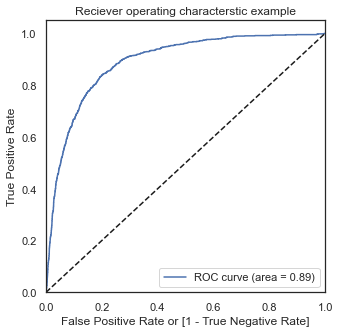

In [ ]:
draw_roc(y_test_pred_final.Sub, y_test_pred_final.Sub_prob)

<AxesSubplot:>

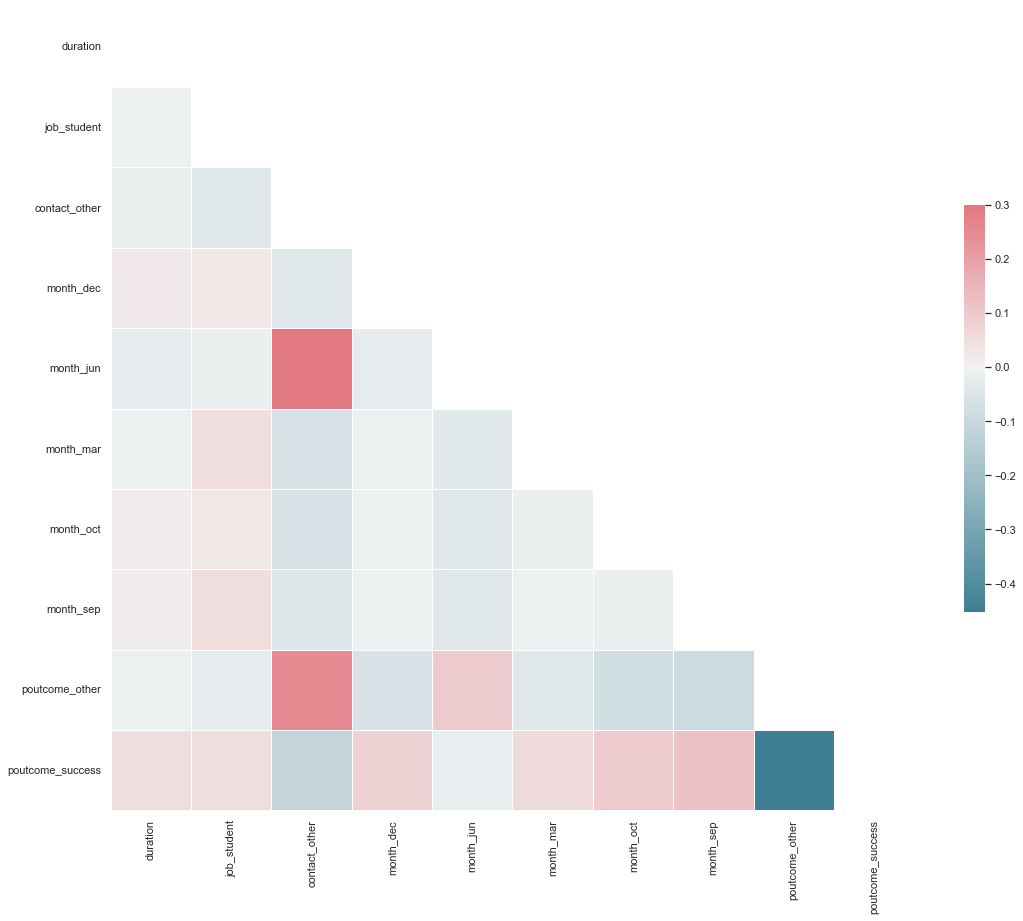

In [ ]:
# New Correlation Matrix
sns.set(style="white")

# Compute the correlation matrix
corr = x_train[x_train.columns[rfe.support_]].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### [Table of Content](#0.1)

### 7. Machine Learning: Classification <a class="anchor" id="7"></a>

![FilterMethods](http://algolytics.com/wp-content/uploads/2018/08/Classification_model_construction.png)

The main objective of this project is to identify the most responsive customers before the marketing campaign so that the bank will be able to efficiently reach out to them, saving time and marketing resources. To achieve this objective, classification algorithms will be employed. By analyzing customer statistics, a classification model will be built to classify all clients into two groups: "yes" to term deposits and "no" to term deposits

### 7.1 Sklearn Logistic Regression and Accuracy<a class="anchor" id="7.1"></a>

In [ ]:
accuracy = {}

feature_selection = LogisticRegression()
feature_selection.fit(x_train[x_train.columns[rfe.support_]], y_train)
ACC = feature_selection.score(x_test[x_test.columns[rfe.support_]],y_test)*100

accuracy['Logistic Regression after Feature Selection'] = ACC
print("Test Accuracy {:.2f}%".format(ACC))

Test Accuracy 89.89%


#### Accuracy on the Feature Selected features have 89.89% Accuracy which is still better as we have eliminated some of the features

In [ ]:
accuracies = {}

lr = LogisticRegression()
lr.fit(x_train, y_train)
acc = lr.score(x_test,y_test)*100

accuracies['Logistic Regression'] = acc
print("Test Accuracy {:.2f}%".format(acc))

Test Accuracy 89.85%


#### Accuracy on all the features is approximately same as we have got for the feature selection features

In [ ]:
# IMPORTANT: first argument is true values, second argument is predicted values
# this produces a 2x2 numpy array (matrix)

#Predictions
y_predict = lr.predict(x_test)
y_pred = feature_selection.predict(x_test[x_test.columns[rfe.support_]])

print('Without Feature Selection','\n', cm(y_test, y_predict))
print('After Feature Selection','\n', cm(y_test, y_pred))

Without Feature Selection 
 [[7741  239]
 [ 679  384]]
After Feature Selection 
 [[7763  217]
 [ 697  366]]


In [ ]:
# print the classification report

print('Without Feature Selection','\n',report(y_test, y_predict))
print('After Feature Selection','\n',report(y_test, y_pred))

Without Feature Selection 
               precision    recall  f1-score   support

           0       0.92      0.97      0.94      7980
           1       0.62      0.36      0.46      1063

    accuracy                           0.90      9043
   macro avg       0.77      0.67      0.70      9043
weighted avg       0.88      0.90      0.89      9043

After Feature Selection 
               precision    recall  f1-score   support

           0       0.92      0.97      0.94      7980
           1       0.63      0.34      0.44      1063

    accuracy                           0.90      9043
   macro avg       0.77      0.66      0.69      9043
weighted avg       0.88      0.90      0.89      9043



In [ ]:
# ROC Curve plotting and finding AUC value
fpr,tpr,thresholds=roc_curve(y_t,feature_selection.predict_proba(x)[:,1])
plt.plot(fpr,tpr,color='red')
auc=roc_auc_score(y,y_pred)

plt.plot(fpr,tpr,color='red',label='logit model(area  = %0.2f)'%auc)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.show()

print('auc accuracy:',auc)

### Without Feature Selection is performing well we will continue with what Modelf or below reasons
+ F1-score for 1's has scored better
+ Accuracy is also slightly higher
+ Recall is higher but precision is lower
+ True Postive Rate is better

### predict_proba method
+ predict_proba method gives the probabilities for the target variable(0 and 1) in this case, in array form.

0 is for probability of Refusal and 1 is for probability of Subscription.

In [ ]:
# As accuracy = 0.8933, which is greater than 0.5; Thus [:,1] Threshold value>0.5=1 else [:,0] Threshold value<0.5=0
lr.predict_proba(x)[:,1]

array([0.0487229 , 0.02541333, 0.01113284, ..., 0.95557715, 0.08618605,
       0.46196165])

### Compare the train-set and test-set accuracy
Now, I will compare the train-set and test-set accuracy to check for overfitting.

#### Check for overfitting and underfitting


In [ ]:
# print the scores on training and test set

print('Training set score: {:.2f}%'.format(lr.score(x_train, y_train)*100))

print('Test set score: {:.2f}%'.format(lr.score(x_test, y_test)*100))

Training set score: 89.71%
Test set score: 89.22%


The training-set accuracy score is 89.71% while the test-set accuracy to be 89.22% These two values are quite comparable. So, there is no question of overfitting

### Compare model accuracy with null accuracy
So, the model accuracy is 89.71%. But, we cannot say that our model is very good based on the above accuracy. We must compare it with the null accuracy. Null accuracy is the accuracy that could be achieved by always predicting the most frequent class.

So, we should first check the class distribution in the test set.

In [ ]:
# check class distribution in test set

y_test.value_counts()

0    7980
1    1063
Name: y, dtype: int64

calculate the percentage of ones
because y_test only contains ones and zeros, we can simply calculate the mean = percentage of ones

In [ ]:
print("Mean of 1's",y_test.mean(),"\n Percentage of 1's",np.round(y_test.mean(),2)*100,'%')

Mean of 1's 0.1175494857901139 
 Percentage of 1's 12.0 %


In [ ]:
# calculate the percentage of zeros
print("Mean of 0's",1-y_test.mean(),"\n Percentage of 0's",np.round(1-y_test.mean(),2)*100,'%')

Mean of 0's 0.8824505142098861 
 Percentage of 0's 88.0 %


In [ ]:
# calculate null accuracy
y_test.value_counts().head(1) / len(y_test)

0    0.882451
Name: y, dtype: float64

This means that a dumb model that always predicts 0 would be right 88% of the time

+ This shows how classification accuracy is not that good as it's close to a dumb model
+ It's a good way to know the minimum we should achieve with our models

<b> Conclusion:

+ Classification accuracy is the easiest classification metric to understand
    + But, it does not tell you the underlying distribution of response values
+ We examine by calculating the null accuracy And, it does not tell you what "types" of errors your classifier is making

### 7.2 Confusion matrix<a class="anchor" id="7.2"></a>
Table that describes the performance of a classification model

A confusion matrix is a tool for summarizing the performance of a classification algorithm. A confusion matrix will give us a clear picture of classification model performance and the types of errors produced by the model. It gives us a summary of correct and incorrect predictions broken down by each category. The summary is represented in a tabular form.

Four types of outcomes are possible while evaluating a classification model performance. These four outcomes are described below:-

True Positives (TP) – True Positives occur when we predict an observation belongs to a certain class and the observation actually belongs to that class.

True Negatives (TN) – True Negatives occur when we predict an observation does not belong to a certain class and the observation actually does not belong to that class.

False Positives (FP) – False Positives occur when we predict an observation belongs to a certain class but the observation actually does not belong to that class. This type of error is called Type I error.

False Negatives (FN) – False Negatives occur when we predict an observation does not belong to a certain class but the observation actually belongs to that class. This is a very serious error and it is called Type II error.

These four outcomes are summarized in a confusion matrix given below.

In [ ]:
# IMPORTANT: first argument is true values, second argument is predicted values
# this produces a 2x2 numpy array (matrix)

#Predictions
y_predict = lr.predict(x_test)

print(cm(y_test, y_predict))

[[7741  239]
 [ 679  384]]


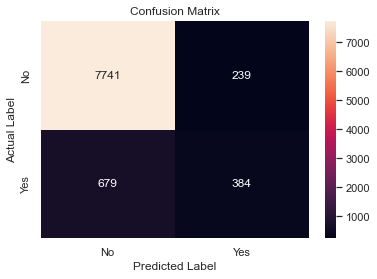

In [ ]:
# plot confusion matrix to describe the performance of classifier.

cm_df=cm(y_test, y_predict)
class_label = ["No", "Yes"]
df_cm = pd.DataFrame(cm_df, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [ ]:
y_predict = lr.predict(x)

print(cm(y, y_predict))

[[38872  1050]
 [ 3422  1867]]


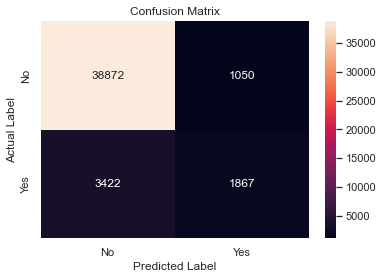

In [ ]:
# plot confusion matrix to describe the performance of classifier.

cm_df=cm(y, y_predict)
class_label = ["No", "Yes"]
df_cm = pd.DataFrame(cm_df, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

<b>Basic terminology

+ True Positives (TP): we correctly predicted that they do have subscription
    + 289
+ True Negatives (TN): we correctly predicted that they don't have subscription
    + 7779
+ False Positives (FP): we incorrectly predicted that they do have subscription (a "Type I error")
    + 774
    + Falsely predict positive
    + Type I error
+ False Negatives (FN): we incorrectly predicted that they don't have subscription (a "Type II error")
    + 201
    + Falsely predict negative
    + Type II error

In [ ]:
# save confusion matrix and slice into four pieces
confusion = cm(y_test, y_predict)
print(confusion)
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[7779  201]
 [ 774  289]]


### Metrics computed from a confusion matrix
Classification Accuracy: Overall, how often is the classifier correct?

In [ ]:
# use float to perform true division, not integer division
print((TP + TN) / float(TP + TN + FP + FN))
print(ac(y_test, y_predict))

0.8921817980758597
0.8921817980758597


### Classification Error: Overall, how often is the classifier incorrect?

Also known as "Misclassification Rate"

In [ ]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print(classification_error)
print(1 - ac(y_test, y_predict))

0.10781820192414023
0.10781820192414027


<b>Recall</b>: When the actual value is positive, how often is the prediction correct?

+ Something we want to maximize
+ How "sensitive" is the classifier to detecting positive instances?
+ Also known as "True Positive Rate" or "Sensitivity"
+ TP / all positive
    + all positive = TP + FN

In [ ]:
recall = TP / float(FN + TP)

print(recall)
print(recall_score(y_test, y_predict))

0.2718720602069614
0.2718720602069614


<b>Specificity</b>: When the actual value is negative, how often is the prediction correct?

+ Something we want to maximize
+ How "specific" (or "selective") is the classifier in predicting positive instances?
+ TN / all negative
    + all negative = TN + FP

In [ ]:
specificity = TN / (TN + FP)

print(specificity)

0.974812030075188


Our classifier

+ Highly specific
+ Not sensitive

<b>False Positive Rate</b>: When the actual value is negative, how often is the prediction incorrect?

In [ ]:
false_positive_rate = FP / float(TN + FP)

print(false_positive_rate)
print(1 - specificity)

0.02518796992481203
0.02518796992481198


<b>Precision</b>: When a positive value is predicted, how often is the prediction correct?

+ How "precise" is the classifier when predicting positive instances?

In [ ]:
precision = TP / float(TP + FP)

print(precision)
print(precision_score(y_test, y_predict))

0.5897959183673469
0.5897959183673469


<b>f1-score
    
+ f1-score is the weighted harmonic mean of precision and recall. The best possible f1-score would be 1.0 and the worst would be 0.0. f1-score is the harmonic mean of precision and recall. So, f1-score is always lower than accuracy measures as they embed precision and recall into their computation. The weighted average of f1-score should be used to compare classifier models, not global accuracy.

In [ ]:
f1_score = 2*((precision_score(y_test, y_predict) * recall_score(y_test, y_predict))/(precision_score(y_test, y_predict) + recall_score(y_test, y_predict)))
f1_score

0.3721828718609143

### The threshold level

In [ ]:
# print the first 10 predicted probabilities of two classes- 0 and 1

y_pred_prob = lr.predict_proba(x_test)[0:10]

y_pred_prob

array([[0.99796514, 0.00203486],
       [0.34381765, 0.65618235],
       [0.98136882, 0.01863118],
       [0.99351352, 0.00648648],
       [0.96711518, 0.03288482],
       [0.97051101, 0.02948899],
       [0.94637008, 0.05362992],
       [0.95604326, 0.04395674],
       [0.92702983, 0.07297017],
       [0.99336123, 0.00663877]])

#### Observations
+ In each row, the numbers sum to 1.
+ There are 2 columns which correspond to 2 classes - 0 and 1.

    + Class 0 - predicted probability that there is no Subscription.

    + Class 1 - predicted probability that there is Subscriptionw.

+ Importance of predicted probabilities

    + We can rank the observations by probability of Subscription or no Subscription.
+ predict_proba process

    + Predicts the probabilities

    + Choose the class with the highest probability

+ Classification threshold level

    + There is a classification threshold level of 0.5.

    + Class 1 - probability of Subscription is predicted if probability > 0.5.

    + Class 0 - probability of no Subscription is predicted if probability < 0.5.

In [ ]:
# store the probabilities in dataframe

y_pred_prob_df = pd.DataFrame(data=y_pred_prob, columns=['Prob of - No Subscription (0)', 'Prob of - Subscription (1)'])

y_pred_prob_df

,Prob of - No Subscription (0),Prob of - Subscription (1)
0,0.997965,0.002035
1,0.343818,0.656182
2,0.981369,0.018631
3,0.993514,0.006486
4,0.967115,0.032885
5,0.970511,0.029489
6,0.946370,0.053630
7,0.956043,0.043957
8,0.927030,0.072970
9,0.993361,0.006639


Text(0, 0.5, 'Frequency')

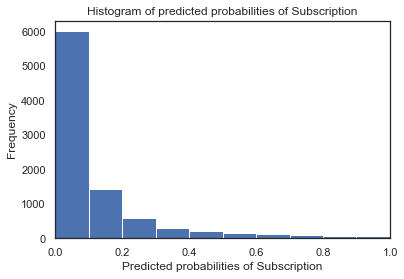

In [ ]:
# store the predicted probabilities for class 1 - Probability of Subscription

y_pred1 = lr.predict_proba(x_test)[:, 1]
# plot histogram of predicted probabilities


# adjust the font size
plt.rcParams['font.size'] = 12


# plot histogram with 10 bins
plt.hist(y_pred1, bins = 10)


# set the title of predicted probabilities
plt.title('Histogram of predicted probabilities of Subscription')


# set the x-axis limit
plt.xlim(0,1)


# set the title
plt.xlabel('Predicted probabilities of Subscription')
plt.ylabel('Frequency')

<b>Observations
+ We can see that the above histogram is highly positive skewed.
+ The first column tell us that there are approximately 6000 observations with probability between 0.0 and 0.1.
+ There are small number of observations with probability > 0.5.
+ So, these small number of observations predict that there will be a Subscription.
+ Majority of observations predict that there will be no Subscription.

### 7.3 Lower the Threshold<a class="anchor" id="7.3"></a>

In [ ]:
from sklearn.preprocessing import binarize

for i in range(1,5):

    cm1=0

    y_pred1 = lr.predict_proba(x_test)[:,1]

    y_pred1 = y_pred1.reshape(-1,1)

    y_pred2 = binarize(y_pred1, threshold=i/10)

    cm1 = cm(y_test, y_pred2)

    print ('With',i/10,'threshold the Confusion Matrix is ','\n\n',cm1,'\n\n',

            'with',cm1[0,0]+cm1[1,1],'correct predictions, ', '\n\n',

            cm1[0,1],'Type I errors( False Positives), ','\n\n',

            cm1[1,0],'Type II errors( False Negatives), ','\n\n',

               'Accuracy score: ', (ac(y_test, y_pred2)), '\n\n',

               'Sensitivity: ',cm1[1,1]/(float(cm1[1,1]+cm1[1,0])), '\n\n',

               'Specificity: ',cm1[0,0]/(float(cm1[0,0]+cm1[0,1])),'\n\n',

                '====================================================', '\n\n')

With 0.1 threshold the Confusion Matrix is  

 [[5812 2168]
 [ 198  865]] 

 with 6677 correct predictions,  

 2168 Type I errors( False Positives),  

 198 Type II errors( False Negatives),  

 Accuracy score:  0.7383611633307531 

 Sensitivity:  0.8137347130761995 

 Specificity:  0.7283208020050125 



With 0.2 threshold the Confusion Matrix is  

 [[7057  923]
 [ 391  672]] 

 with 7729 correct predictions,  

 923 Type I errors( False Positives),  

 391 Type II errors( False Negatives),  

 Accuracy score:  0.8546942386376203 

 Sensitivity:  0.632173095014111 

 Specificity:  0.8843358395989975 



With 0.3 threshold the Confusion Matrix is  

 [[7472  508]
 [ 553  510]] 

 with 7982 correct predictions,  

 508 Type I errors( False Positives),  

 553 Type II errors( False Negatives),  

 Accuracy score:  0.8826716797522945 

 Sensitivity:  0.4797742238946378 

 Specificity:  0.9363408521303258 



With 0.4 threshold the Confusion Matrix is  

 [[7663  317]
 [ 674  389]] 

 wi

#### Comments
+ In binary problems, the threshold of 0.5 is used by default to convert predicted probabilities into class predictions.
+ Threshold can be adjusted to increase sensitivity or specificity.
+ Sensitivity and specificity have an inverse relationship. Increasing one would always decrease the other and vice versa.
+ We can see that increasing the threshold level results in increased accuracy.
+ Adjusting the threshold level should be one of the last step you do in the model-building process.

### 7.4 ROC - AUC <a class="anchor" id="7.4"></a>
#### ROC Curve
Another tool to measure the classification model performance visually is ROC Curve. ROC Curve stands for Receiver Operating Characteristic Curve. An ROC Curve is a plot which shows the performance of a classification model at various classification threshold levels.

The ROC Curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold levels.

True Positive Rate (TPR) is also called Recall. It is defined as the ratio of TP to (TP + FN).

False Positive Rate (FPR) is defined as the ratio of FP to (FP + TN).

In the ROC Curve, we will focus on the TPR (True Positive Rate) and FPR (False Positive Rate) of a single point. This will give us the general performance of the ROC curve which consists of the TPR and FPR at various threshold levels. So, an ROC Curve plots TPR vs FPR at different classification threshold levels. If we lower the threshold levels, it may result in more items being classified as positve. It will increase both True Positives (TP) and False Positives (FP).

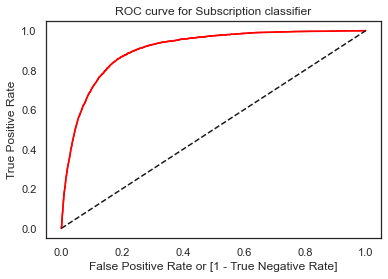

AUC-ROC Score: 0.6656459469463876


In [ ]:
# ROC Curve plotting and finding AUC value
fpr,tpr,thresholds=roc_curve(y,lr.predict_proba(x)[:,1])
plt.plot(fpr,tpr,color='red')
auc=roc_auc_score(y_test,y_predict)

plt.plot(fpr,tpr,color='red',label='logit model(area  = %0.2f)'%auc)
plt.plot([0,1],[0,1],'k--')
plt.title('ROC curve for Subscription classifier')
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.show()

print('AUC-ROC Score:',auc)

### ROC AUC Score
ROC AUC stands for Receiver Operating Characteristic - Area Under Curve. It is a technique to compare classifier performance. In this technique, we measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

So, ROC AUC is the percentage of the ROC plot that is underneath the curve.

In [ ]:
from sklearn.metrics import roc_auc_score
curve = roc_auc_score(y_test, y_predict)
print(curve)

0.6233420451410747


<b>Comments
+ ROC AUC is a single number summary of classifier performance. The higher the value, the better the classifier.

+ ROC AUC of our model approaches towards 0.5. So, we can conclude that our classifier doesn't do a good job in predicting whether it will subscription or not.

### 7.5 Finding the Optimcal Threshold Value<a class="anchor" id="7.5"></a>

In [ ]:
final_prediction = lr.predict_proba(x)[:,1]
fpr,tpr,thresholds=roc_curve(y,lr.predict_proba(x)[:,1])

accuracy_ls = []
for thres in thresholds:
    y_pred = np.where(final_prediction>thres,1,0)
    accuracy_ls.append(ac(y, y_pred, normalize=True))

accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)],axis=1)
accuracy_ls.columns = ['thresholds', 'accuracy']
accuracy_ls.sort_values(by='accuracy', ascending=False, inplace=True)
accuracy_ls.head()

,thresholds,accuracy
1361,0.460619,0.896441
1362,0.460343,0.896441
1387,0.455343,0.896441
1385,0.455451,0.896441
1389,0.455202,0.896441


If this was a use case for balaced dataset we would have gone with accuracy to select the optimal threshold value, otherwise it depends when data is imbalanced sometimes recall is more important than precision and sometimes the other way around and sometimes both are more important then we will go with F1-Score to select the optimal threshold value.

In [ ]:
final_prediction = lr.predict_proba(x)[:,1]
fpr,tpr,thresholds=roc_curve(y,lr.predict_proba(x)[:,1])

f1_score_ls = []
for thres in thresholds:
    y_pred = np.where(final_prediction>thres,1,0)
    f1_score_ls.append(f1_score(y, y_pred))

f1_score_ls = pd.concat([pd.Series(thresholds), pd.Series(f1_score_ls)],axis=1)
f1_score_ls.columns = ['thresholds', 'f1_score']
f1_score_ls.sort_values(by='f1_score', ascending=False, inplace=True)
f1_score_ls.head()

,thresholds,f1_score
3525,0.200874,0.515515
3523,0.200905,0.515480
3526,0.200847,0.515475
3524,0.200875,0.515440
3521,0.200985,0.515405


### 7.6 Classification Report<a class="anchor" id="7.6"></a>

In [ ]:
# print the classification report

print(report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7980
           1       0.59      0.27      0.37      1063

    accuracy                           0.89      9043
   macro avg       0.75      0.62      0.66      9043
weighted avg       0.87      0.89      0.87      9043



Classification report shows the precision, recall, F1 and support scores for the Logistic Regression classification model.

+ Precision of 0 (the client said no) represents that for all instances predicted as no subscription, the percentage of clients that actually said no is 91%.


+ Recall is the ability of a classifier to find all positive instances. Recall of 0 indicates that for all clients that actually said no, the model predicts 97% correctly that they would decline the offer.

In general, the report shows that <b>Logistic Regression model has great predictive power to identify the customers who would not subscribe to the term deposit</b>. However, because of the limited number of clients accepting the term deposit, there is a <b>need for stratified sampling or rebalancing to deal with this structural weakness</b> before we conclude whether LR algorithm can accurately classify those who are more likely to subscribe.

### 7.7 Predictions<a class="anchor" id="7.7"></a>

In [ ]:
#Predictions
y_pred = lr.predict(x)

# Creating a datframe to with actual value and predicted value

predict = pd.DataFrame({'Actual':y,'Predicted':y_pred})
predict

,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
45206,1,1
45207,1,0
45208,1,1
45209,0,0


#### [Table of Contents](#0.1)

### 8. Synthetic Minority Oversampling Technique <a class="anchor" id="8"></a>
A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary.

One way to solve this problem is to oversample the examples in the minority class. This can be achieved by simply duplicating examples from the minority class in the training dataset prior to fitting a model. This can balance the class distribution but does not provide any additional information to the model.

An improvement on duplicating examples from the minority class is to synthesize new examples from the minority class. This is a type of data augmentation for tabular data and can be very effective.

Perhaps the most widely used approach to synthesizing new examples is called the Synthetic Minority Oversampling TEchnique, or SMOTE for short

In [ ]:
# import imblearn library and resample the original data using SMOTE technique
from sklearn.neighbors import DistanceMetric
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(x_train, y_train)
print('Original dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_smote))

Original dataset shape Counter({0: 31942, 1: 4226})
Resampled dataset shape Counter({1: 31942, 0: 31942})


In [ ]:
# training a Logistic Regression model on SMOTE data

lr_smote = LogisticRegression()
lr_smote.fit(X_smote, y_smote)

LogisticRegression()

In [ ]:
accuracies = {}

acc = lr_smote.score(x_test,y_test)*100

accuracies['Logistic Regression'] = acc
print("Test Accuracy {:.2f}%".format(acc))

Test Accuracy 82.28%


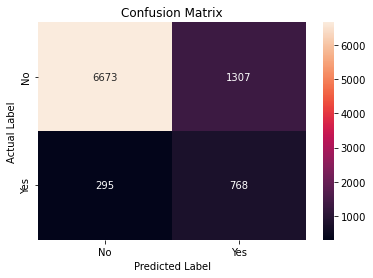

In [ ]:
# plot confusion matrix to describe the performance of classifier.
#Predictions
y_predict_smote = lr_smote.predict(x_test)

cm_df_smote=cm(y_test, y_predict_smote)
class_label = ["No", "Yes"]
df_cm_smote = pd.DataFrame(cm_df_smote, index = class_label, columns = class_label)
sns.heatmap(df_cm_smote, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [ ]:
# print the classification report

print(report(y_test, y_predict_smote))

              precision    recall  f1-score   support

           0       0.96      0.84      0.89      7980
           1       0.37      0.72      0.49      1063

    accuracy                           0.82      9043
   macro avg       0.66      0.78      0.69      9043
weighted avg       0.89      0.82      0.85      9043



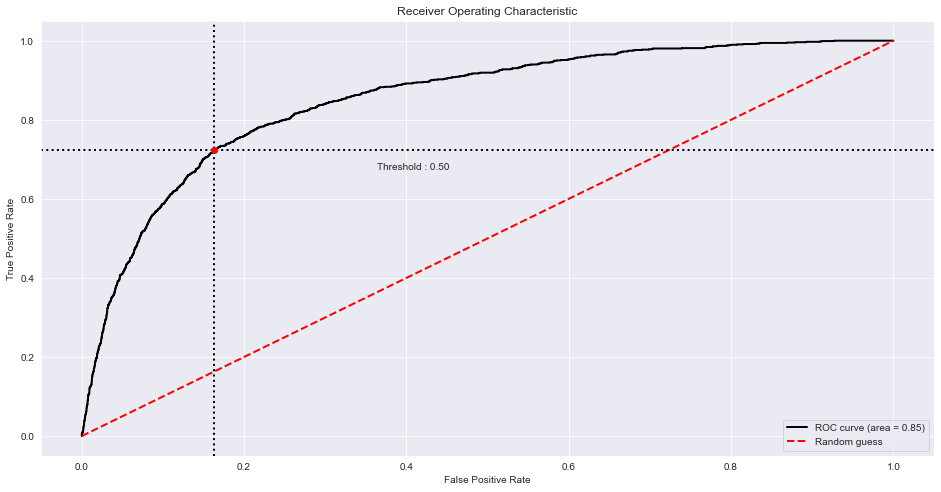

In [ ]:
# let's compute the AUC curve for the model we developed on SMOTE data

from plot_metric.functions import BinaryClassification

bc = BinaryClassification(y_test, lr_smote.predict_proba(x_test)[:,1],  labels=[0, 1])
plt.figure(figsize=(16, 8))
bc.plot_roc_curve()
plt.show()

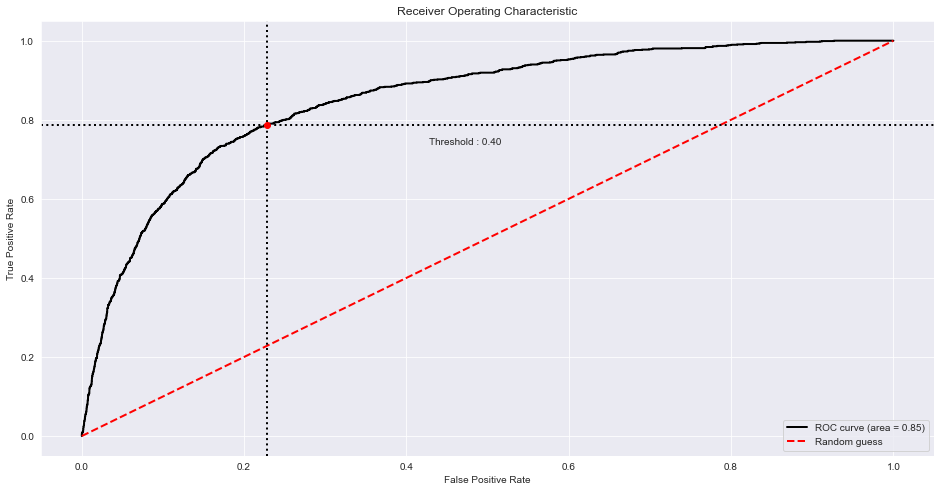

In [ ]:
# let's use another probability threshold so that we can get to the elbow position in the above curve

bc = BinaryClassification(y_test, lr_smote.predict_proba(x_test)[:,1], threshold=0.4, labels=[0, 1])
plt.figure(figsize=(16, 8))
bc.plot_roc_curve()
plt.show()

<AxesSubplot:>

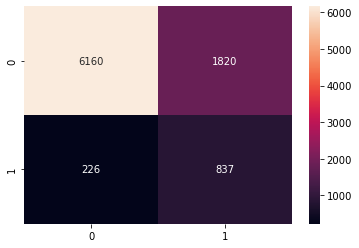

In [ ]:
# compute the probabilites of test observations using rf_smote model

y_pred_proba = lr_smote.predict_proba(x_test)[:,1]
# compare these probabilities against the probability threshold of 6% rather than the default threshold of 50%

y_pred_labels = (y_pred_proba >= 0.4)
# plot the confusion matrix

sns.heatmap(cm(y_test, y_pred_labels), annot=True, fmt='0.0f')

In [ ]:
# print the classification report

print(report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.96      0.77      0.86      7980
           1       0.32      0.79      0.45      1063

    accuracy                           0.77      9043
   macro avg       0.64      0.78      0.65      9043
weighted avg       0.89      0.77      0.81      9043



## 9. Conclusion <a class="anchor" id="9"></a>
<b>Key outcomes of the analysis are the recommendations for future marketing campaigns:</b>

+ The customer's account balance has a huge influence on the campaign's outcome. People with account balance above 1490$ $ $  are more likely to subscribe for term deposit, so future address those customers.


+ The customer's age affects campaign outcome as well. Future campains should concentrate on customers from age categories below 30 years old and above 50 years old.


+ Number of contacts with the customer during the campaign is also very important. The number of contacts with the customer shouldn't exceed 4.

#### [Table of Contents](#0.1)

![FilterMethods](https://media3.giphy.com/media/fxI1G5PNC5esyNlIUs/200w.webp?cid=ecf05e47i9j4r455mnasxjlpu7nia4br3eqm8mg51vqvusi4&rid=200w.webp&ct=g)